In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.scale import LogitScale
import gc
import joblib
import time
import numpy as np
import pandas as pd
import nibabel as nib
import statsmodels.api as sm                                                                                        
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import zscore
from joblib import Parallel, delayed
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
from joblib import load
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from utils import train_data_normalization, Timer, net_size_info, conv2_labels
import os, sys, six 
import scipy as sp
import h5py
import scipy.io as sio
import neuropythy as ny
import matplotlib as mpl
from sklearn.mixture import GaussianMixture

In [2]:
# path settings
cifti_path = '/nfs/z1/userhome/zzl-xsk/NOD'
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
# input path
resp_path = pjoin(work_dir, 'prep/brain_response')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
image_activations_path = pjoin(work_dir, 'prep/image_activations')
concate_feature_path = pjoin(work_dir, 'prep/roi-concate')
retino_path = pjoin(work_dir, 'build/retinoparams')
guass_path = pjoin(work_dir, 'build/gaussianparams')
avgrf_path = pjoin(work_dir, 'prep/image_mask')
res_fig_dir = pjoin(work_dir, 'vis/results_plots')

### 0. 预先准备

In [3]:
# 按照 selectivity 给每个 channel 分类
net_layer = 'googlenet_conv2'
layerlabel = 'conv2'
df = pd.read_csv(pjoin(work_dir, f'anal/unit-selectivity/DNN-unit-tuning-{layerlabel}.csv'))
stim_type = ['color', 'gabor', 'curv', 'texture'] #
metric = 'max'
classify = np.argmax(np.c_[df[f'color_{metric}'], df[f'gabor_{metric}'], df[f'curv_{metric}'], df[f'natural_{metric}']], axis=1) #
selectivity_label = {'gabor':[], 'color':[], 'curv':[], 'texture':[]}
for unit, keyid in enumerate(classify[0:63]):
    selectivity_label[stim_type[keyid]].append(unit)
label_dict = selectivity_label
# 装载 indices 和颜色
setcolors = ["#175b91","#b9dcf4","#bf4e40","#061e31",] # plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
draw_sorting = []
draw_colors = []
draw_ticks = []
draw_tickslabels = []
for key, indices in label_dict.items():
    iset = list(label_dict.keys()).index(key)
    set_color = setcolors[iset]
    draw_sorting.extend(list(indices))
    draw_colors.extend(len(indices)*[set_color])
    draw_ticks.append(len(indices))
    draw_tickslabels.append(key)
draw_ticks = [0] + list(np.cumsum(draw_ticks))
print(draw_ticks, draw_tickslabels)
print(draw_sorting)
# 分 家族类型 
gabor_family = ['gabor']
color_family = ['color']
curv_family = ['curv']
texture_family = ['texture']
gabor_channel, color_channel, curv_channel, texture_channel = [], [], [], []

for labelname, indices in label_dict.items():
    if labelname in gabor_family:
        gabor_channel.extend(indices)
    if labelname in color_family:
        color_channel.extend(indices)
    if labelname in curv_family:
        curv_channel.extend(indices)    
    if labelname in texture_family:
        texture_channel.extend(indices)
print('gabor | color | curvature | natural texture')
print(len(gabor_channel), len(color_channel), len(curv_channel), len(texture_channel))

[0, 28, 29, 30, 63] ['gabor', 'color', 'curv', 'texture']
[0, 2, 4, 5, 11, 12, 14, 15, 19, 20, 22, 30, 31, 32, 36, 39, 40, 41, 44, 46, 47, 50, 51, 53, 54, 56, 59, 62, 26, 7, 1, 3, 6, 8, 9, 10, 13, 16, 17, 18, 21, 23, 24, 25, 27, 28, 29, 33, 34, 35, 37, 38, 42, 43, 45, 48, 49, 52, 55, 57, 58, 60, 61]
gabor | color | curvature | natural texture
28 1 1 33


In [ ]:
if 'conv2' in net_layer:
    if 63 in draw_sorting:
        try:
            gabor_channel.pop(gabor_channel.index(63)) # 扔掉没用的
            print('63 in gabor')
        except ValueError:
            try:
                color_channel.pop(color_channel.index(63)) # 扔掉没用的
                print('63 in color')
            except ValueError:
                texture_channel.pop(texture_channel.index(63)) # 扔掉没用的
                print('63 in texture')

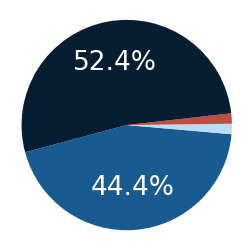

In [35]:
# 数据
sizes = [len(gabor_channel), len(color_channel), len(curv_channel), len(texture_channel)]
labels = ['Gabor family', 'Color family', 'Shape family', 'Texture family'] #
colors = ["#175b91","#b9dcf4","#bf4e40", "#061e31"]
text_color = 'white'
#["#af9c6e","#b6ba99","#bad7c3"]
def autopct_format(values):
    def my_format(pct):
        # 计算当前扇形的半径
        total = sum(values)
        val = int(round(pct*total/100.0))
        # 移动文本的位置
        radius = 0.9  # 调整这个值使得标签更靠近圆心
        return '{:.1f}%'.format(pct, val) if pct > 5 else ''
    return my_format
# 绘制饼图labels=labels,
plt.style.use('default')
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(sizes,  autopct=autopct_format(sizes), startangle=195, colors=colors,textprops={'color': text_color,'size':19})

# 等比例显示，确保饼图是圆形
ax.axis('equal')

# 显示图表
plt.show()

In [52]:
45 in texture_channel

True

## 分析一、 Inception V1 conv1 - conv3 与 gabor编码模型

### 结果 1.1: 低级视皮层四个模型的表现比较  

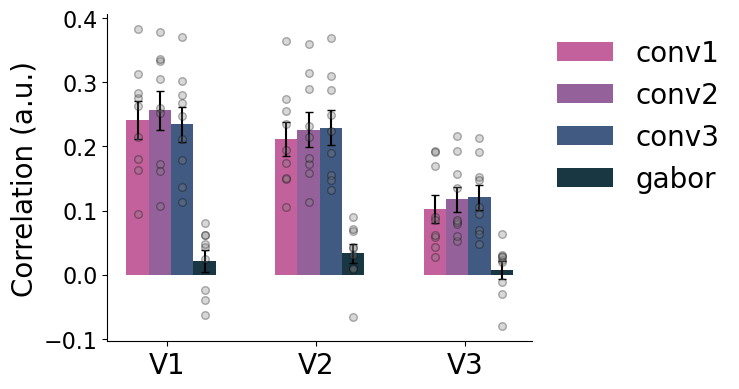

In [21]:
#### 绘制 V1 上各模型的表现
model_rois = ['V1', 'V2', 'V3']#, 'V1','V2'
model_layer = ['conv1', 'conv2', 'conv3','gabor'] #  'inception3a', ,'pca','ica'
model_colors =[ "#bc5090","#8a508f", "#2c4875","#00202e"]
performance_path = pjoin(work_dir, 'build/roi-concatemodel/performance')

# 初始化数据存储结构
gabor_performances = []
conv2_performances = []
maxpool2_performances = []
maxpool1_performances = []


for roi in model_rois:
    gabor_model = pjoin(performance_path, f'all-sub_model-gabor-linear_{roi}_test-corr.npy')
    maxpool1_model = pjoin(performance_path, f'all-sub_model-googlenet-maxpool1-linear_{roi}_test-corr.npy')
    conv2_model = pjoin(performance_path, f'all-sub_model-googlenet-conv2-linear_{roi}_test-corr.npy')
    maxpool2_model = pjoin(performance_path, f'all-sub_model-googlenet-maxpool2-linear_{roi}_test-corr.npy')
    
    if np.load(gabor_model).ndim==3:
        gabor_cor = np.array([ np.load(gabor_model)[_][0,1] for _ in range(9)])
    else:
        gabor_cor = np.load(gabor_model)

    if np.load(maxpool1_model).ndim==3:
        maxpool1_cor = np.array([np.load(maxpool1_model)[_][0,1] for _ in range(9)])
    else:
        maxpool1_cor = np.load(maxpool1_model)

    if np.load(conv2_model).ndim==3:
        conv2_cor = np.array([ np.load(conv2_model)[_][0,1] for _ in range(9)])
    else:
        conv2_cor = np.load(conv2_model)
    
    if np.load(maxpool2_model).ndim==3:
        maxpool2_cor = np.array([np.load(maxpool2_model)[_][0,1] for _ in range(9)])
    else:
        maxpool2_cor = np.load(maxpool2_model)

    gabor_performances.append(gabor_cor)
    conv2_performances.append(conv2_cor)
    maxpool2_performances.append(maxpool2_cor)
    maxpool1_performances.append(maxpool1_cor)

plt.style.use('default')
# 准备绘图数据
scale_factor = 0.8
fig, ax = plt.subplots(figsize=(6/scale_factor, 3.2/scale_factor))
roi_indices = np.arange(len(model_rois))  #
bar_width = 0.15
performances = [maxpool1_performances, conv2_performances, maxpool2_performances,  gabor_performances]# inception3a_performances, pca_performances, ica_performances,
# 对于测试集和验证集分别绘制四个模型的性能
for i, layer in enumerate(model_layer):
    # 计算每个ROI的平均性能和标准误
    means = [np.mean(performances[i][_]) for _ in range(len(model_rois))]
    sems = [np.std(performances[i][_], ddof=1) / np.sqrt(len(performances[i][_])) for _ in range(len(model_rois))]
    
    # 绘制柱状图
    rects = ax.bar(roi_indices + i * bar_width, means, bar_width, yerr=sems, label=model_layer[i],
                   capsize=3, color=model_colors[i], alpha=0.9)
    
    # # 在柱状图上添加原始性能数据点
    for idx, perf in enumerate([performances[i][_] for _ in range(len(model_rois))]):
        ax.scatter(np.ones_like(perf) * (roi_indices[idx] + i*bar_width), perf, color='grey', s=30, 
                   edgecolor='black', linewidth=1., alpha=0.3, zorder=3)

# 添加图表细节
ax.set_ylabel('Correlation (a.u.)', fontsize=20)
ax.set_xticks([])
ax.set_xticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend( bbox_to_anchor=(1, 1), loc='upper left', ncol=1, frameon=False, fontsize=20)
plt.xticks([0.2, 1.2, 2.2], ['V1', 'V2', 'V3'], fontsize=20)
plt.yticks(fontsize=16) 
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.savefig(pjoin(res_fig_dir, 'roi-encoding-performance.svg'), format='svg')
plt.show()

### 结果 1.2: 各层全模型权重的被试间一致性矩阵

0.7462192839917693

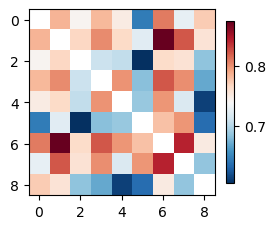

In [38]:
nodroi_models = {}
rois = ['V1', 'V2', 'V3']
layer = 'conv2'
space = 'ica'
# 加载模型
if layer != 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel')
elif layer == 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel_feature-preprocessed')

if space == 'raw':
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if layer in _])
elif space != 'raw':
    nod_model_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}')
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if 'conv2' in _])
# 加载模型参数
nodroi_weights = {}
for roi in rois:
    nodroi_weights[roi] = [joblib.load(roi_model).coef_ for roi_model in nodroi_models[roi]]

weights = nodroi_weights['V1']

diagnan = np.eye(9)
diagnan[diagnan==1] = np.nan
plt.figure(figsize=(3,3))
plt.imshow(np.corrcoef(np.array(weights)) - diagnan, cmap='RdBu_r')
plt.colorbar(shrink=0.7)
plt.xticks([0,2,4,6,8])
np.nanmean(np.corrcoef(np.array(weights)) - diagnan)

## 分析二、权重统计检验 与 简单标准刺激探测

### 结果 2.1: （每个channel系数的t-test筛选）每个脑区显著的conv2特征weights

In [4]:
nodroi_models = {}
rois = ['V1', 'V2', 'V3']
layer = 'conv2'
space = 'raw'#'pca'
# 加载模型
if layer != 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel')
elif layer == 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel_feature-preprocessed')

nod_model_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}')
for roi in rois:
    nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if layer in _])

# 加载模型参数
nodroi_weights = {}
for roi in rois:
    nodroi_weights[roi] = [joblib.load(roi_model).coef_ for roi_model in nodroi_models[roi]]
print('V1', len(nodroi_weights['V1']))
print('V2', len(nodroi_weights['V2']))
print('V3', len(nodroi_weights['V3']))

V1 9
V2 9
V3 9


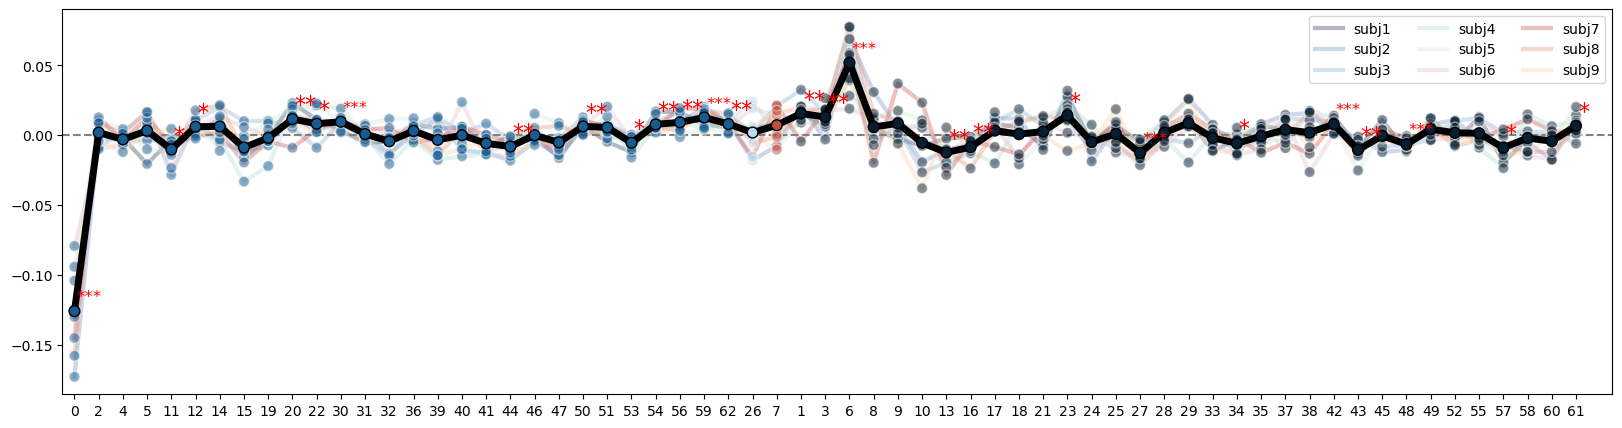

In [27]:
# 看看单ROI的情况
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
weights = nodroi_weights['V2']

# 画个大图试试
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)+1))
sub_betas[:, 0:len(weights[0])] = np.array(weights)

sub_betas = sub_betas[:, np.array(draw_sorting)]
mean_betas = sub_betas.mean(axis=0)
# plots
for isub in range(sub_betas.shape[0]):
    # if isub in [0,5,7]:
    ax.plot(sub_betas[isub], color=subcolors[isub], lw=3, alpha=0.4, label=f'subj{isub+1}')
    ax.scatter(np.arange(len(draw_sorting)), sub_betas[isub], color=draw_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.legend(ncol=3)
ax.plot(mean_betas, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(draw_sorting)), mean_betas, color=draw_colors, s=60, edgecolors='black', zorder=5)
ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

from scipy import stats
_, p_value = stats.ttest_1samp(sub_betas, 0)
for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
    infotxt = '*'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center', zorder=7)
for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
    infotxt = '**'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
for pos in np.where(p_value < 0.001)[0]:
    infotxt = '***'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
# ax.set_xticks(draw_ticks[0:-1])
# ax.set_xticklabels(draw_tickslabels)
# ax.set_yscale('logit')
ax.set_xticks(np.arange(63))
ax.set_xticklabels(draw_sorting)
plt.show()

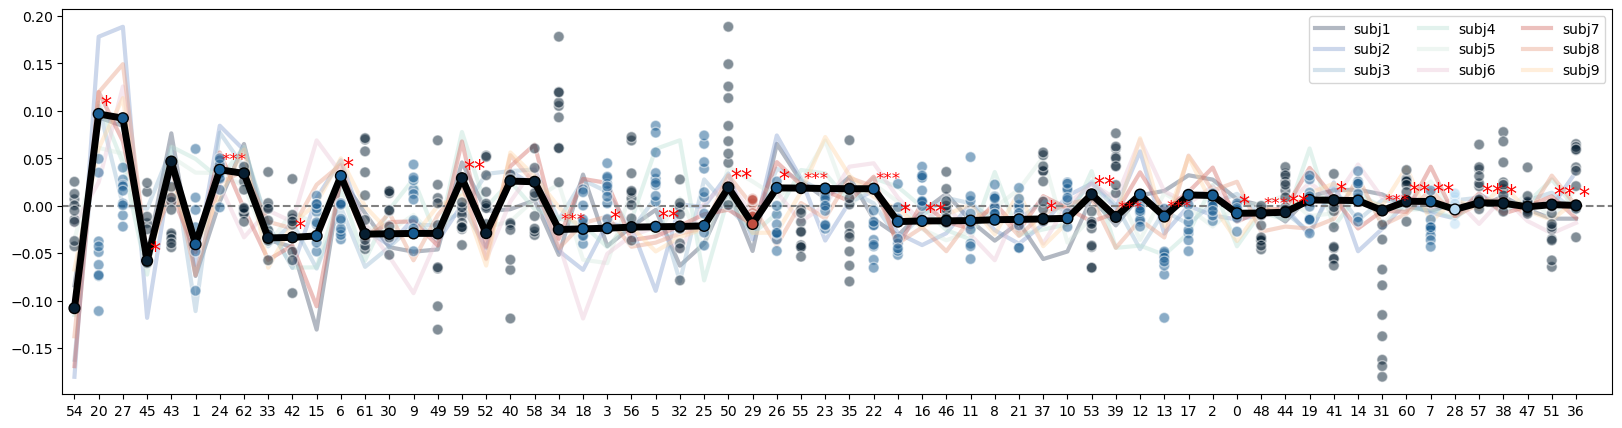

In [54]:
# 看看单ROI的情况
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
weights = nodroi_weights['V2']

# 画个大图试试
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)+1))
sub_betas[:, 0:len(weights[0])] = np.array(weights)

sub_betas = sub_betas[:, np.array(draw_sorting)]
mean_betas = sub_betas.mean(axis=0)
sorted_indices = np.flip(np.argsort(np.abs(mean_betas)))
sorted_mean_betas = mean_betas[sorted_indices]
sorted_sub_betas = sub_betas[:, sorted_indices]

sorted_draw_sorting = np.array(draw_sorting)[sorted_indices]
sorted_draw_colors = np.array(draw_colors)[sorted_indices]
# plots
for isub in range(sub_betas.shape[0]):
    sorted_sub_beta = sorted_sub_betas[isub]
    ax.plot(sorted_sub_beta, color=subcolors[isub], lw=3, alpha=0.4, label=f'subj{isub+1}')
    ax.scatter(np.arange(len(sorted_draw_sorting)), sub_betas[isub], color=sorted_draw_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.legend(ncol=3)
ax.plot(sorted_mean_betas, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(sorted_draw_sorting)), sorted_mean_betas, color=sorted_draw_colors, s=60, edgecolors='black', zorder=5)
ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

from scipy import stats
_, p_value = stats.ttest_1samp(sub_betas, 0)
for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
    infotxt = '*'
    ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center', zorder=7)
for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
    infotxt = '**'
    ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
for pos in np.where(p_value < 0.001)[0]:
    infotxt = '***'
    ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
# ax.set_xticks(draw_ticks[0:-1])
# ax.set_xticklabels(draw_tickslabels)
ax.set_xticks(np.arange(63))
ax.set_xticklabels(sorted_indices)
plt.gcf().set_facecolor('white')
# ax.set_yscale('logit')
plt.show()

只看显著的特征

<ipython-input-47-9f7e0ebeca22>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(draw_tickslabels)


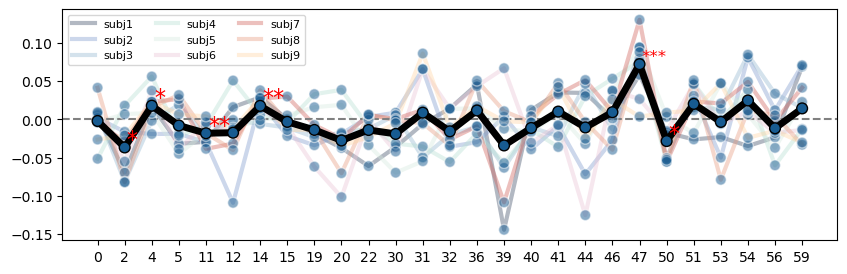

In [47]:
# 只挑出显著的特征，看看单ROI的情况
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
weights = nodroi_weights['V1']

# 数据准备
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
sub_betas[:, 0:len(weights[0])] = np.array(weights)
sub_betas = sub_betas[:, np.array(draw_sorting)]
mean_betas = sub_betas.mean(axis=0)
# 挑出显著的特征
sigidx = np.where(p_value < 0.05)[0] # np.where(fdr_corrected[0]==True)[0] # 
sub_betas = sub_betas[:,sigidx]
mean_betas = mean_betas[sigidx]
sort_by_weights = np.argsort(np.abs(mean_betas))

select_sorting = np.array(draw_sorting)[sigidx]
select_colors = np.array(draw_colors)[sigidx]


num_feature = len(sigidx)
# 只挑出显著的特征，看看单ROI的情况

# 画个大图试试
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10,3))
# plots
for isub in range(sub_betas.shape[0]):
    # if isub in [0,5,7]:
    ax.plot(sub_betas[isub], color=subcolors[isub], lw=3, alpha=0.4, label=f'subj{isub+1}')
    ax.scatter(np.arange(len(select_sorting)), sub_betas[isub], color=select_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.legend(ncol=3, fontsize=8)
ax.plot(mean_betas, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(select_sorting)), mean_betas, color=select_colors, s=60, edgecolors='black', zorder=5)
# ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

from scipy import stats
_, p_value = stats.ttest_1samp(sub_betas, 0)
for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
    infotxt = '*'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center', zorder=7)
for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
    infotxt = '**'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
for pos in np.where(p_value < 0.001)[0]:
    infotxt = '***'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
# ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.set_xticks(np.arange(num_feature))
ax.set_xticklabels(select_sorting)

plt.show()

按照权重绝对值大小排序

<ipython-input-84-be7e164cf3cb>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(draw_tickslabels)


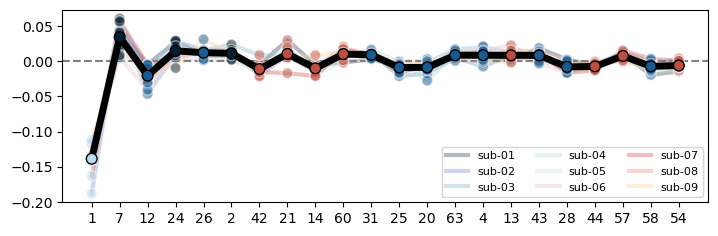

In [84]:
# 只挑出显著的特征，看看单ROI的情况
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
roi = 'V1'
weights = nodroi_weights[roi]

# 数据准备
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
sub_betas[:, 0:len(weights[0])] = np.array(weights)
sub_betas = sub_betas[:, np.array(draw_sorting)]
_, p_value = stats.ttest_1samp(sub_betas, 0)
mean_betas = sub_betas.mean(axis=0)
# 挑出显著的特征
sigidx = np.where(p_value < 0.05)[0] # np.where(fdr_corrected[0]==True)[0] # 
select_sorting = np.array(draw_sorting)[sigidx]
select_colors = np.array(draw_colors)[sigidx]
sub_betas = sub_betas[:,sigidx]
mean_betas = mean_betas[sigidx]

abs_mean_betas = np.abs(mean_betas)
sorted_indices = np.flip(np.argsort(abs_mean_betas))
sorted_mean_betas = mean_betas[sorted_indices]
sorted_sub_betas = sub_betas[:, sorted_indices]
sorted_draw_sorting = np.array(select_sorting)[sorted_indices]
sorted_draw_colors = np.array(select_colors)[sorted_indices]

num_feature = len(sigidx)
# 只挑出显著的特征，看看单ROI的情况

# 画个大图试试
plt.style.use('default')
scale_factor = 1.2
fig, ax = plt.subplots(1, 1, figsize=(10/scale_factor,3/scale_factor))
# plots
for isub in range(sorted_sub_betas.shape[0]):
    ax.plot(sorted_sub_betas[isub], color=subcolors[isub], lw=3, alpha=0.4, label=f'sub-0{isub+1}')
    ax.scatter(np.arange(len(sorted_draw_sorting)), sorted_sub_betas[isub], color=sorted_draw_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.legend(ncol=3, fontsize=8)
ax.plot(sorted_mean_betas, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(sorted_draw_sorting)), sorted_mean_betas, color=sorted_draw_colors, s=60, edgecolors='black', zorder=5)
# ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

# from scipy import stats
# _, p_value = stats.ttest_1samp(sorted_sub_betas, 0)
# for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
#     infotxt = '*'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='left', verticalalignment='center', zorder=7)
# for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
#     infotxt = '**'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='left', verticalalignment='center',zorder=7)
# for pos in np.where(p_value < 0.001)[0]:
#     infotxt = '***'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
#     horizontalalignment='left', verticalalignment='center',zorder=7)
# ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.set_xticks(np.arange(num_feature))
ax.set_xticklabels(sorted_draw_sorting+1)
plt.savefig(pjoin(res_fig_dir, f'roi-{roi}_layer-{layer}_space-{space}_weights.svg'), format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [80]:
# 按照 selectivity 给每个 channel 分类
net_layer = 'googlenet_conv2'
layerlabel = 'conv2'
# df = pd.read_csv(pjoin(work_dir, f'anal/unit-selectivity/DNN-unit-tuning-{layerlabel}.csv'))
df = pd.read_csv(pjoin(work_dir, f'anal/neural-selectivity/tuningsummary/pca-tuning-{layerlabel}.csv'))
stim_type = ['color', 'gabor', 'curv', 'texture'] #
metric = 'mean'
classify = np.argmax(np.c_[df[f'color_{metric}'], df[f'gabor_{metric}'], df[f'curv_{metric}'], df[f'natural_{metric}']], axis=1) #
selectivity_label = {'gabor':[], 'color':[], 'curv':[], 'texture':[]}
for unit, keyid in enumerate(classify[0:63]):
    selectivity_label[stim_type[keyid]].append(unit)
label_dict = selectivity_label
# 装载 indices 和颜色
setcolors = ["#175b91","#b9dcf4","#bf4e40","#061e31",] # plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
draw_sorting = []
draw_colors = []
draw_ticks = []
draw_tickslabels = []
for key, indices in label_dict.items():
    iset = list(label_dict.keys()).index(key)
    set_color = setcolors[iset]
    draw_sorting.extend(list(indices))
    draw_colors.extend(len(indices)*[set_color])
    draw_ticks.append(len(indices))
    draw_tickslabels.append(key)
draw_ticks = [0] + list(np.cumsum(draw_ticks))
print(draw_ticks, draw_tickslabels)
print(draw_sorting)
# 分 家族类型 
gabor_family = ['gabor']
color_family = ['color']
curv_family = ['curv']
texture_family = ['texture']
gabor_channel, color_channel, curv_channel, texture_channel = [], [], [], []

for labelname, indices in label_dict.items():
    if labelname in gabor_family:
        gabor_channel.extend(indices)
    if labelname in color_family:
        color_channel.extend(indices)
    if labelname in curv_family:
        curv_channel.extend(indices)    
    if labelname in texture_family:
        texture_channel.extend(indices)
print('gabor | color | curvature | natural texture')
print(len(gabor_channel), len(color_channel), len(curv_channel), len(texture_channel))

[0, 25, 37, 59, 63] ['gabor', 'color', 'curv', 'texture']
[2, 3, 4, 5, 9, 11, 14, 19, 24, 25, 26, 27, 29, 30, 35, 36, 42, 44, 46, 52, 54, 57, 58, 61, 62, 0, 7, 10, 16, 17, 18, 22, 31, 34, 39, 47, 48, 12, 13, 15, 20, 21, 28, 32, 33, 37, 38, 40, 41, 43, 45, 49, 50, 51, 53, 55, 56, 59, 60, 1, 6, 8, 23]
gabor | color | curvature | natural texture
25 12 22 4


只显示top

<ipython-input-10-add74fce0cdf>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(draw_tickslabels[0:n_top])


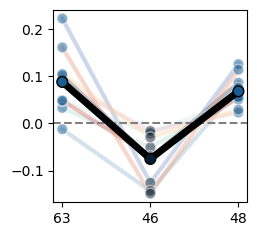

In [10]:
# 只挑出显著的特征，看看单ROI的情况
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
roi = 'V3'
weights = nodroi_weights[roi]

# 数据准备
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
sub_betas[:, 0:len(weights[0])] = np.array(weights)
sub_betas = sub_betas[:, np.array(draw_sorting)]
_, p_value = stats.ttest_1samp(sub_betas, 0)
mean_betas = sub_betas.mean(axis=0)
# 挑出显著的特征
sigidx = np.where(p_value < 0.05)[0] # np.where(fdr_corrected[0]==True)[0] # 
select_sorting = np.array(draw_sorting)[sigidx]
select_colors = np.array(draw_colors)[sigidx]
sub_betas = sub_betas[:,sigidx]
mean_betas = mean_betas[sigidx]

abs_mean_betas = np.abs(mean_betas)
sorted_indices = np.flip(np.argsort(abs_mean_betas))
sorted_mean_betas = mean_betas[sorted_indices]
sorted_sub_betas = sub_betas[:, sorted_indices]
sorted_draw_sorting = np.array(select_sorting)[sorted_indices]
sorted_draw_colors = np.array(select_colors)[sorted_indices]

num_feature = len(sigidx)
# 只挑出显著的特征，看看单ROI的情况

n_top = 3
# 画个大图试试
plt.style.use('default')
scale_factor = 1.2
fig, ax = plt.subplots(1, 1, figsize=(3/scale_factor,3/scale_factor))
# plots
for isub in range(sorted_sub_betas.shape[0]):
    ax.plot(sorted_sub_betas[isub][0:n_top], color=subcolors[isub], lw=3, alpha=0.4, label=f'sub-0{isub+1}')
    ax.scatter(np.arange(len(sorted_draw_sorting))[0:n_top], sorted_sub_betas[isub][0:n_top], color=sorted_draw_colors[0:n_top], s=60, alpha=0.5, edgecolors='white', zorder=4)
# ax.legend(ncol=3, fontsize=8)
ax.plot(sorted_mean_betas[0:n_top], color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(sorted_draw_sorting))[0:n_top], sorted_mean_betas[0:n_top], color=sorted_draw_colors[0:n_top], s=60, edgecolors='black', zorder=5)
# ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

# from scipy import stats
# _, p_value = stats.ttest_1samp(sorted_sub_betas, 0)
# for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
#     infotxt = '*'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='left', verticalalignment='center', zorder=7)
# for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
#     infotxt = '**'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='left', verticalalignment='center',zorder=7)
# for pos in np.where(p_value < 0.001)[0]:
#     infotxt = '***'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
#     horizontalalignment='left', verticalalignment='center',zorder=7)
# ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels[0:n_top])
ax.set_xticks(np.arange(num_feature)[0:n_top])
ax.set_xticklabels(sorted_draw_sorting[0:n_top]+1)
plt.savefig(pjoin(res_fig_dir, f'roi-{roi}_layer-{layer}_space-{space}_weights-TOP{n_top}.svg'), format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

### 结果 2.2: 每个脑区显著特征各类占比的饼图

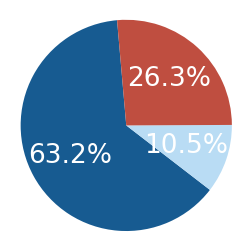

In [104]:
# 数据
weights = nodroi_weights['V3'].copy()

# 数据准备
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
sub_betas[:, 0:len(weights[0])] = np.array(weights)
sub_betas = sub_betas[:, np.array(draw_sorting)]
_, p_value = stats.ttest_1samp(sub_betas, 0)
# 挑出显著的特征
sigidx = np.where(p_value < 0.05)[0] # np.where(fdr_corrected[0]==True)[0] # 
select_sorting = np.array(draw_sorting)[sigidx]

net_layer = 'googlenet_conv2'
layerlabel = 'conv2'
df = pd.read_csv(pjoin(work_dir, f'anal/unit-selectivity/DNN-unit-tuning-{layerlabel}.csv'))
stim_type = ['color', 'gabor', 'curv'] #, 'texture'
metric = 'max'
classify = np.argmax(np.c_[df[f'color_{metric}'], df[f'gabor_{metric}'], df[f'curv_{metric}'],], axis=1) # df[f'natural_{metric}']
selectivity_label = {'gabor':[], 'color':[], 'curv':[], 'texture':[]}
for unit, keyid in enumerate(classify[0:63]):
    selectivity_label[stim_type[keyid]].append(unit)
label_dict = selectivity_label

selectivity_label = {'gabor':[], 'color':[], 'curv':[], 'texture':[]}
for unit, keyid in enumerate(classify[select_sorting]):
    selectivity_label[stim_type[keyid]].append(unit)
label_dict = selectivity_label
# 分 家族类型 
gabor_family = ['gabor']
color_family = ['color']
curv_family = ['curv']
texture_family = ['texture']
gabor_channel, color_channel, curv_channel, texture_channel = [], [], [], []

for labelname, indices in label_dict.items():
    if labelname in gabor_family:
        gabor_channel.extend(indices)
    if labelname in color_family:
        color_channel.extend(indices)
    if labelname in curv_family:
        curv_channel.extend(indices)    
    if labelname in texture_family:
        texture_channel.extend(indices)

sizes = [len(gabor_channel), len(color_channel), len(curv_channel), len(texture_channel)]
labels = ['Gabor family', 'Color family', 'Shape family', 'Texture family'] #
colors = ["#175b91","#b9dcf4","#bf4e40", "#061e31"]
text_color = 'white'
#["#af9c6e","#b6ba99","#bad7c3"]
def autopct_format(values):
    def my_format(pct):
        # 计算当前扇形的半径
        total = sum(values)
        val = int(round(pct*total/100.0))
        # 移动文本的位置
        radius = 0.9  # 调整这个值使得标签更靠近圆心
        return '{:.1f}%'.format(pct, val) if pct > 3 else ''
    return my_format
# 绘制饼图labels=labels,
plt.style.use('default')
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(sizes,  autopct=autopct_format(sizes), startangle=95, colors=colors,textprops={'color': text_color,'size':19})

# 等比例显示，确保饼图是圆形
ax.axis('equal')

# 显示图表
plt.show()

## 分析三、显著特征的最优刺激生成 与 调谐性质的估计

### 结果 3: 每个显著特征的可视化及其在简单刺激属性上的选择性

In [106]:
sigfeatures = []
for roi in ['V1', 'V2', 'V3']:
    weights = nodroi_weights[roi].copy()

    # 数据准备
    sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
    sub_betas[:, 0:len(weights[0])] = np.array(weights)
    sub_betas = sub_betas[:, np.array(draw_sorting)]
    _, p_value = stats.ttest_1samp(sub_betas, 0)
    # 挑出显著的特征
    sigidx = np.where(p_value < 0.05)[0] # np.where(fdr_corrected[0]==True)[0] #
    print(roi,np.sort(np.array(draw_sorting)[sigidx].tolist())) 
    sigfeatures.extend(np.array(draw_sorting)[sigidx].tolist())
np.unique(sigfeatures)

V1 [ 1  2  4  8 10 11 14 18 21 24 25 28 29 33 34 35 37 42 45 47 49 50 57 58
 60 61 62]
V2 [ 1  2  5  7  8  9 10 14 20 21 24 25 28 30 34 35 37 40 42 45 47 48 49 51
 54 55 57 60 61 62]
V3 [ 1  7  8 10 14 21 25 28 35 42 43 45 47 48 55 57 60 61 62]


array([ 1,  2,  4,  5,  7,  8,  9, 10, 11, 14, 18, 20, 21, 24, 25, 28, 29,
       30, 33, 34, 35, 37, 40, 42, 43, 45, 47, 48, 49, 50, 51, 54, 55, 57,
       58, 60, 61, 62])

In [107]:
np.unique(sigfeatures).shape

(38,)

In [14]:
raw_path = '/nfs/z1/userhome/zzl-xsk/Featurespace/vis/neural-selectivity-plots'

In [25]:
# 剪裁
from PIL import Image, ImageOps
def crop_and_border(img, size=90):
    
    # 获取图片的宽度和高度
    width, height = img.size
    
    # 计算中心区域的左上角和右下角坐标
    left = (width - size) // 2
    top = (height - size) // 2
    right = left + size
    bottom = top + size
    
    # 剪裁图片
    img_cropped = img.crop((left, top, right, bottom))
    
    # 添加黑色边框
    img_bordered = ImageOps.expand(img_cropped, border=int(size/9), fill='gray')
    
    # 保存处理后的图片
    return img_bordered

# 设置图片路径和新图像尺寸NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/
image_folder = pjoin(work_dir, 'vis/optimalimages/showinfig')
image_files = sorted([ pjoin(image_folder, _) for _ in os.listdir(image_folder)])
num_rows = 4
num_cols = 8
new_image_size = (120, 120)  # 新的图片大小为50x50

# 创建一个新的空白图像
output_image = Image.new('RGB', (num_cols * new_image_size[0], num_rows * new_image_size[1]))

# 定义灰色的目标值和容差
target_gray = (128, 128, 128)
tolerance = 20
imgs = []
# 加载图片并按照指定的行列顺序排列
for i, imagename in enumerate(image_files):
    if i >= 50:  # 只需要前51张图片
        break
    img = Image.open(imagename)
    
    img = crop_and_border(img, size=40)
    # 将非黑色像素变为白色
    img = img.resize(new_image_size, Image.Resampling.LANCZOS)  # 调整图片大小为50x50
    if '45' in imagename:
        imgs.append([45, img])
    if '47' in imagename:
        imgs.append([47, img])
    if '62' in imagename:
        imgs.append([62, img])    
    # 计算当前图片的位置
    x_pos = (i % num_cols) * new_image_size[0]
    y_pos = (i // num_cols) * new_image_size[1]
    print(i, imagename)
    output_image.paste(img, (x_pos, y_pos))

# 保存新图像
figsave_dir = pjoin(work_dir, 'vis/optimalimages')
output_image.save(pjoin(res_fig_dir, f'SigFeatures.png'))
output_image.close()

0 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/showinfig/unit-1-T5.0_5.0.png
1 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/showinfig/unit-10-T8.1_8.0.png
2 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/showinfig/unit-11-T9.7_10.0.png
3 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/showinfig/unit-14-T8.2_8.0.png
4 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/showinfig/unit-18-T8.9_9.0.png
5 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/showinfig/unit-2-T7.4_7.0.png
6 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalima

In [125]:
imgs[0][1].save(pjoin(figsave_dir, f'P62.png'))
imgs[1][1].save(pjoin(figsave_dir, f'P{imgs[1][0]}.png'))
imgs[2][1].save(pjoin(figsave_dir, f'P{imgs[2][0]}.png'))

## 分析四、脑区特征偏好轴的最有刺激生成 与 调谐性质估计

### 结果 4: 每个脑区被试间平均特征偏好轴的刺激梯度（2-4张）及其简单属性刺激选择性

In [76]:
# 剪裁
from PIL import Image, ImageOps
def crop_and_border(img, size=90):
    
    # 获取图片的宽度和高度
    width, height = img.size
    
    # 计算中心区域的左上角和右下角坐标
    left = (width - size) // 2
    top = (height - size) // 2
    right = left + size
    bottom = top + size
    
    # 剪裁图片
    img_cropped = img.crop((left, top, right, bottom))
    
    # 添加黑色边框
    img_bordered = ImageOps.expand(img_cropped, border=int(size/9), fill='gray')
    
    # 保存处理后的图片
    return img_bordered
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C

def adjust_RF(receptive_field):
    cur_receptive_field = receptive_field.copy()
    cur_receptive_field = cur_receptive_field + np.abs(np.min(cur_receptive_field, None)) + 1
    thres = np.min(cur_receptive_field) + 0.5*(np.max(cur_receptive_field) - np.min(cur_receptive_field)) #

    cur_receptive_field[cur_receptive_field < thres] = 0
    cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)

    return cur_receptive_field

def construct_RF(fieldsize, A=1, x=0, y=0, sigma_x=3.6, sigma_y=3.6, C=0):
    """
    # 创建假想体素感受野
    # default params
    # A, x, y, sigma_x, sigma_y, C = 1, 0, 0, 3.6, 3.6, 0
    """
    i = np.linspace(-8., 8., fieldsize)
    j = np.linspace(8., -8., fieldsize)
    i, j = np.meshgrid(i, j)
    return adjust_RF(gaussian_2d((i, j), A, x, y, sigma_x, sigma_y, C))


# 设置图片路径和新图像尺寸NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/
# grads = [f"F{_}-grad" for _ in [0,1,6,57,59,62]] #"selectpc0
grads = ['dv2v1other', 'dv3v2other']#, 'dv2v1sig', 'dv3v2sig'
# grads = ['v1-gradient', 'v2-gradient', 'v3-gradient']
# grads = ['selectpc41', 'selectpc3']
for grad in grads:
    image_folder = pjoin(work_dir, f'vis/optimalimages/targetvalue/pca_axes/{grad}')
    # image_folder = pjoin(work_dir, f'vis/optimalimages/targetvalue/subtuning/{grad}')
    image_files = sorted([ pjoin(image_folder, _) for _ in os.listdir(image_folder)])
    num_rows = 1#4#1
    num_cols = 2#1#4
    new_image_size = (200, 200)  # 新的图片大小为50x50

    # 创建一个新的空白图像
    output_image = Image.new('RGB', (num_cols * new_image_size[0], num_rows * new_image_size[1]))

    # 定义灰色的目标值和容差
    target_gray = (128, 128, 128)
    tolerance = 20
    imgs = []
    # 加载图片并按照指定的行列顺序排列
    for i, imagename in enumerate(image_files):
        if i >= 50:  # 只需要前51张图片
            break
        img = Image.open(imagename)
        
        img = crop_and_border(img, size=70)
        # 将非黑色像素变为白色
        img = img.resize(new_image_size, Image.Resampling.LANCZOS)  # 调整图片大小为50x50
        mask = construct_RF(img.width, sigma_x=6, sigma_y=6)
        pixels = img.load()
        for x in range(img.width):
            for y in range(img.height):
                if mask[x,y] == 0:
                    pixels[x, y] = tuple((255*np.array([1.,1.,1.])).astype(np.int))
        # 计算当前图片的位置
        x_pos = (i % num_cols) * new_image_size[0]
        y_pos = (i // num_cols) * new_image_size[1]
        print(i, imagename)
        output_image.paste(img, (x_pos, y_pos))

    # 保存新图像
    figsave_dir = pjoin(work_dir, 'vis/optimalimages')
    output_image.save(pjoin(figsave_dir, f'{grad}.png'), 'PNG', optimize=True)
    output_image.close()

0 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/pca_axes/dv2v1other/sub-mean-dv2v1-others-46-T-4_-11.1.png
1 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/pca_axes/dv2v1other/sub-mean-dv2v1-others-46-T4_8.1.png
0 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/pca_axes/dv3v2other/sub-mean-dv3v2-others-46-T-6_-4.1.png
1 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/pca_axes/dv3v2other/sub-mean-dv3v2-others-46-T6_13.5.png


In [29]:
## 每个轴的梯度都画出啦
# 剪裁
from PIL import Image, ImageOps
def crop_and_border(img, size=90):
    
    # 获取图片的宽度和高度
    width, height = img.size
    
    # 计算中心区域的左上角和右下角坐标
    left = (width - size) // 2
    top = (height - size) // 2
    right = left + size
    bottom = top + size
    
    # 剪裁图片
    img_cropped = img.crop((left, top, right, bottom))
    
    # 添加黑色边框
    img_bordered = ImageOps.expand(img_cropped, border=int(size/9), fill='gray')
    
    # 保存处理后的图片
    return img_bordered
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C

def adjust_RF(receptive_field):
    cur_receptive_field = receptive_field.copy()
    cur_receptive_field = cur_receptive_field + np.abs(np.min(cur_receptive_field, None)) + 1
    thres = np.min(cur_receptive_field) + 0.5*(np.max(cur_receptive_field) - np.min(cur_receptive_field)) #

    cur_receptive_field[cur_receptive_field < thres] = 0
    cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)

    return cur_receptive_field

def construct_RF(fieldsize, A=1, x=0, y=0, sigma_x=3.6, sigma_y=3.6, C=0):
    """
    # 创建假想体素感受野
    # default params
    # A, x, y, sigma_x, sigma_y, C = 1, 0, 0, 3.6, 3.6, 0
    """
    i = np.linspace(-8., 8., fieldsize)
    j = np.linspace(8., -8., fieldsize)
    i, j = np.meshgrid(i, j)
    return adjust_RF(gaussian_2d((i, j), A, x, y, sigma_x, sigma_y, C))


# 设置图片路径和新图像尺寸NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/
# grads = [f"F{_}-grad" for _ in [0,1,6,57,59,62]] #"selectpc0
# grads = ['dv2v1sig', 'dv3v2sig', 'dv2v1other', 'dv3v2other']
axis_type = 'ica'
axes_dir = pjoin(work_dir, f'vis/optimalimages/targetvalue/{axis_type}_axes/')#axes
all_images = os.listdir(axes_dir)
grads = np.arange(63)
for grad in grads:
    # image_folder = pjoin(work_dir, f'vis/optimalimages/targetvalue/pca_axes/{grad}')
    axis_name = axis_type.replace('a', '')
    images = [ _ for _ in all_images if f'{axis_name}-{grad}-' in _  and  '6' in _.split('_')[0].split('-')[-1]  ]
    image_folder = axes_dir
    all_image_files = sorted([ pjoin(image_folder, _) for _ in images])
    image_files = [all_image_files[0], all_image_files[-1]]
    num_rows = 1
    num_cols = 2
    new_image_size = (200, 200)  # 新的图片大小为50x50

    # 创建一个新的空白图像
    output_image = Image.new('RGB', (num_cols * new_image_size[0], num_rows * new_image_size[1]))

    # 定义灰色的目标值和容差
    target_gray = (128, 128, 128)
    tolerance = 20
    imgs = []
    # 加载图片并按照指定的行列顺序排列
    for i, imagename in enumerate(image_files):
        if i >= 50:  # 只需要前51张图片
            break
        img = Image.open(imagename)
        
        img = crop_and_border(img, size=70)
        # 将非黑色像素变为白色
        img = img.resize(new_image_size, Image.Resampling.LANCZOS)  # 调整图片大小为50x50
        mask = construct_RF(img.width, sigma_x=6, sigma_y=6)
        pixels = img.load()
        for x in range(img.width):
            for y in range(img.height):
                if mask[x,y] == 0:
                    pixels[x, y] = tuple((255*np.array([1.,1.,1.])).astype(np.int))
        # 计算当前图片的位置
        x_pos = (i % num_cols) * new_image_size[0]
        y_pos = (i // num_cols) * new_image_size[1]
        print(i, imagename)
        output_image.paste(img, (x_pos, y_pos))

    # 保存新图像
    figsave_dir = pjoin(work_dir, 'vis/optimalimages/axes-grad')
    os.makedirs(figsave_dir, exist_ok=True)
    output_image.save(pjoin(figsave_dir, f'{axis_type}_{grad}.png'), 'PNG', optimize=True)
    output_image.close()

0 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/ica_axes/ic-0-T-6_-1.8.png
1 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/ica_axes/ic-0-T6_10.2.png
0 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/ica_axes/ic-1-T-6_-9.1.png
1 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/ica_axes/ic-1-T6_2.9.png
0 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/ica_axes/ic-2-T-6_-1.8.png
1 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/optimalimages/targetvalue/ica_axes/ic-2-T6_10.2.png
0 /nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretin

In [30]:
from PIL import Image
import glob

# 图片尺寸
img_width, img_height = 400, 200

# 行和列的数量
rows, cols = 8, 8  # 8x8 网格

# 创建拼接大图的尺寸
big_image_width = cols * img_width
big_image_height = rows * img_height

# 创建空白的大图
big_image = Image.new('RGB', (big_image_width, big_image_height))

# 读取所有图片
axgrad_dir = f'{work_dir}/vis/optimalimages/axes-grad'
images = sorted(glob.glob(f'{work_dir}/vis/optimalimages/axes-grad/*.png'))  # 根据实际情况设置路径和扩展名assert len(images) == 63, "需要确保图片数量为 63"

# 逐行逐列放置图片
for index in range(63):
    # img = Image.open(img_path)
    imag_path = pjoin(axgrad_dir, f'{axis_type}_{index}.png')
    img = Image.open(imag_path)
    img = img.resize((img_width, img_height))  # 确保图片大小一致
    
    # 确定放置的行列位置
    row = index % cols
    col = index // cols
    
    # 计算图片在大图中的放置位置
    x = col * img_width
    y = row * img_height
    
    # 粘贴到大图上
    big_image.paste(img, (x, y))

# 保存最终的拼接大图
big_image.save(f'{work_dir}/vis/optimalimages/axes-grad/big_image.png', 'PNG', optimize=True)

## 分析五、特征轴变换后conv2模型对各脑区预测表现的比较 与 预测表现随特征个数增加的变化

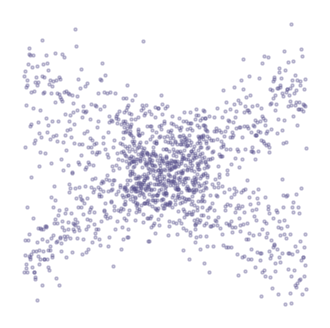

In [34]:
x1 = np.r_[np.linspace(-1,1,500), np.linspace(-0.3,0.3,200)]
x2 = np.r_[np.linspace(-1,1,500), np.linspace(-0.3,0.3,200)]
y1 = 10 * (x1 + 0.2* np.random.randn(700)) + 2 * np.random.randn(700)
y2 = -10 * (x2 + 0.35* np.random.randn(700)) + 2 * np.random.randn(700)
y = np.c_[y1, y2]
x = np.c_[x1, x2]
plt.style.use('default')
plt.figure(figsize=(4,4))
plt.scatter(x, y, s=5, alpha=0.3, color='#58508d')
plt.axis('off')
plt.show()


### 结果 5.1.1：原始轴、主轴与独立轴表征下conv模型对各脑区的预测表现

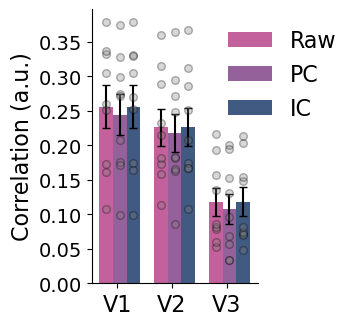

In [45]:
#### 绘制 V1 上各模型的表现
model_rois = ['V1', 'V2', 'V3']#, 'V1','V2'
model_layer = ['raw', 'pca', 'ica'] #  'inception3a', ,'pca','ica'
model_colors =[ "#bc5090","#8a508f", "#2c4875","#00202e"]
performance_path = pjoin(work_dir, 'build/roi-concatemodel/performance')

# 初始化数据存储结构
raw_performances = []
pca_performances = []
ica_performances = []

for roi in model_rois:
    performance_path = pjoin(work_dir, f'build/roi-concatemodel_feature-raw/performance')
    raw_model = pjoin(performance_path, f'all-sub_model-googlenet-conv2-linear_{roi}_test-corr.npy')
    performance_path = pjoin(work_dir, f'build/roi-concatemodel_feature-pca/performance')
    pca_model = pjoin(performance_path, f'all-sub_model-googlenet-conv2-linear_{roi}_test-corr.npy')
    performance_path = pjoin(work_dir, f'build/roi-concatemodel_feature-ica/performance')
    ica_model = pjoin(performance_path, f'all-sub_model-googlenet-conv2-linear_{roi}_test-corr.npy')

    if np.load(raw_model).ndim==3:
        raw_cor = np.array([ np.load(raw_model)[_][0,1] for _ in range(9)])
    else:
        raw_cor = np.load(raw_model)

    if np.load(pca_model).ndim==3:
        pca_cor = np.array([ np.load(pca_model)[_][0,1] for _ in range(9)])
    else:
        pca_cor = np.load(pca_model)

    if np.load(ica_model).ndim==3:
        ica_cor = np.array([ np.load(ica_model)[_][0,1] for _ in range(9)])
    else:
        ica_cor = np.load(ica_model)

    raw_performances.append(raw_cor)
    pca_performances.append(pca_cor)
    ica_performances.append(ica_cor)

plt.style.use('default')
# 准备绘图数据
scale_factor = 0.95
fig, ax = plt.subplots(figsize=(3.2/scale_factor, 3.2/scale_factor))
roi_indices = np.arange(len(model_rois))  #
bar_width = 0.25
performances = [raw_performances, pca_performances, ica_performances]# inception3a_performances, pca_performances, ica_performances,
# 对于测试集和验证集分别绘制四个模型的性能
for i, layer in enumerate(model_layer):
    # 计算每个ROI的平均性能和标准误
    means = [np.mean(performances[i][_]) for _ in range(len(model_rois))]
    sems = [np.std(performances[i][_], ddof=1) / np.sqrt(len(performances[i][_])) for _ in range(len(model_rois))]
    
    # 绘制柱状图
    label_name = model_layer[i].replace('ca','c').upper()
    if label_name =='RAW': label_name='Raw'
    rects = ax.bar(roi_indices + i * bar_width, means, bar_width, yerr=sems, label=label_name,
                   capsize=3, color=model_colors[i], alpha=0.9)
    
    # # 在柱状图上添加原始性能数据点
    for idx, perf in enumerate([performances[i][_] for _ in range(len(model_rois))]):
        ax.scatter(np.ones_like(perf) * (roi_indices[idx] + i*bar_width), perf, color='grey', s=30, 
                   edgecolor='black', linewidth=1., alpha=0.3, zorder=3)

# 添加图表细节
ax.set_ylabel('Correlation (a.u.)', fontsize=16)
ax.set_xticks([])
ax.set_xticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(bbox_to_anchor=(0.7, 1), loc='upper left', ncol=1, frameon=False, fontsize=16)
plt.xticks([0.2, 1.2, 2.2], ['V1', 'V2', 'V3'], fontsize=16)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.gcf().set_facecolor('white')
layer = 'conv2'
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-all_performance.svg'), format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

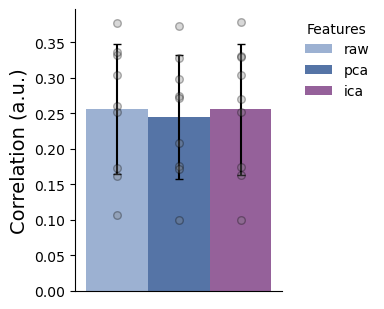

In [38]:
#### 绘制 V1 上各模型的表现
model_rois = ['V1']
model_layer = ['raw', 'pca', 'ica'] # 
# datasets = ['Test', 'Validation']
model_colors = ["#91a9ce", "#42659c","#8a508f", "#2c4875","#00202e"]
# ["#e25fe2","#c451d5","#a742c8","#8934bb","#6c25ae","#4e17a1"]


# 初始化数据存储结构
raw_performances = []
pca_performances = []
ica_performances = []

for roi in model_rois:
    performance_path = pjoin(work_dir, f'build/roi-concatemodel_feature-raw/performance')
    raw_model = pjoin(performance_path, f'all-sub_model-googlenet-conv2-linear_{roi}_test-corr.npy')
    performance_path = pjoin(work_dir, f'build/roi-concatemodel_feature-pca/performance')
    pca_model = pjoin(performance_path, f'all-sub_model-googlenet-conv2-linear_{roi}_test-corr.npy')
    performance_path = pjoin(work_dir, f'build/roi-concatemodel_feature-ica/performance')
    ica_model = pjoin(performance_path, f'all-sub_model-googlenet-conv2-linear_{roi}_test-corr.npy')

    if np.load(raw_model).ndim==3:
        raw_cor = np.array([ np.load(raw_model)[_][0,1] for _ in range(9)])
    else:
        raw_cor = np.load(raw_model)

    if np.load(pca_model).ndim==3:
        pca_cor = np.array([ np.load(pca_model)[_][0,1] for _ in range(9)])
    else:
        pca_cor = np.load(pca_model)

    if np.load(ica_model).ndim==3:
        ica_cor = np.array([ np.load(ica_model)[_][0,1] for _ in range(9)])
    else:
        ica_cor = np.load(ica_model)

    raw_performances.append(raw_cor)
    pca_performances.append(pca_cor)
    ica_performances.append(ica_cor)

plt.style.use('default')
# 准备绘图数据
fig, ax = plt.subplots(figsize=(4, 3.2))
roi_indices = np.arange(len(model_rois))  #
bar_width = 0.15
performances = [raw_performances, pca_performances, ica_performances]
# 对于测试集和验证集分别绘制四个模型的性能
for i, layer in enumerate(model_layer):
    # 计算每个ROI的平均性能和标准误
    means = [np.mean(performances[i]) ]
    sems = [np.std(performances[i], ddof=1) / np.sqrt(len(performances[i])) ]
    
    # 绘制柱状图
    rects = ax.bar(roi_indices + i * bar_width, means, bar_width, yerr=sems, label=model_layer[i],
                   capsize=3, color=model_colors[i], alpha=0.9)
    
    # 在柱状图上添加原始性能数据点
    for idx, perf in enumerate([performances[i]]):
        ax.scatter(np.ones_like(perf) * (roi_indices[idx] + i*bar_width), perf, color='grey', s=30, 
                   edgecolor='black', linewidth=1., alpha=0.3, zorder=3)

# 添加图表细节
# ax.set_xlabel('Dataset')
ax.set_ylabel('Correlation (a.u.)', fontsize=14)
# ax.set_title('Performance by Dataset and ROI')
# ax.set_xticks([roi_indices[0] + _*bar_width for _ in range(len(model_layer))])
ax.set_xticks([])
ax.set_xticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xticklabels(['conv2', 'inception3a', 'maxpool2', 'gabor'])
ax.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, frameon=False)
plt.xlim([-0.1,0.4])
plt.tight_layout()
plt.show()

### 结果 5.1.2：被试间一致性

0.3839166552280707

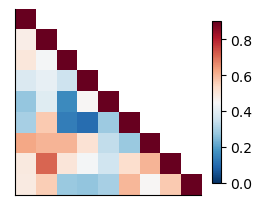

In [79]:
# 读取所有model
nodroi_models = {}
rois = ['V1', 'V2', 'V3']
layer = 'conv2'
space = 'raw'
# 加载模型
if layer != 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel')
elif layer == 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel_feature-preprocessed')

if space == 'raw':
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if layer in _])
elif space != 'raw':
    nod_model_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}')
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if 'conv2' in _])
# 加载模型参数
nodroi_weights = {}
for roi in rois:
    nodroi_weights[roi] = [joblib.load(roi_model).coef_ for roi_model in nodroi_models[roi]]

mats = []
for roi in ['V1', 'V2', 'V3']:
    weights = nodroi_weights[roi]
    n = 9
    rows, cols = np.triu_indices(n, k=1)
    diagnan = np.eye(9)
    diagnan[diagnan==1] = np.nan
    weights = zscore(np.array(weights), axis=1)
    mats.append(np.corrcoef(weights))

n = 9
rows, cols = np.triu_indices(n, k=1)
draw_mat = np.nanmean(np.array(mats), axis=0)
draw_mat[rows, cols] = np.nan

factor = 1
plt.figure(figsize=(3/factor,3/factor))
# draw_mat = draw_mat - diagnan
plt.imshow(draw_mat, cmap='RdBu_r', vmin=0, vmax=0.9)
plt.colorbar(shrink=0.7)
plt.xticks([0,2,4,6,8], [f'sub-0{_}' for _ in [1, 3, 5, 7,9]], rotation=25)
plt.yticks([1,3,5,7], [f'sub-0{_}' for _ in [2, 4, 6, 8]], )
plt.xticks([])
plt.yticks([])

# 获取当前轴 (Axes)
ax = plt.gca()

# 隐藏上边框和右边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{space}_weights-ISC-coloarbar.svg'), format='svg', bbox_inches='tight', pad_inches=0.05)
np.nanmean(np.corrcoef(np.array(weights)) - diagnan)

In [33]:
for roi in ['V1', 'V2', 'V3']:
    nod_model_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}')
    save_tuning_path = pjoin(work_dir, 'build/roi-concatemodel_feature-pca/subtuning')
    nodweights = np.array(nodroi_weights[roi])
    space = 'pcatuning'
    sub_space_tuning = {}
    for isub, sub in enumerate([f'sub-{_+1}' for _ in range(9)]):
        tuning_name = f'{sub}-{roi}-{space}'
        sub_space_tuning[tuning_name] = nodweights[isub]
    sub_space_tuning[f"sub-mean-{roi}-pcatuning"] = np.mean(nodweights, axis=0)
    np.save(pjoin(save_tuning_path, f'allsub_{roi}-tuning.npy'), sub_space_tuning)

### 结果5.1.3：随特征轴的增加预测表现的变化

In [13]:
# 按照 selectivity 给每个 channel 分类
layerlabel = 'conv2' # NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/
axis = 'pca'
df = pd.read_csv(pjoin(work_dir, f'anal/neural-selectivity/tuningsummary/{axis}-tuning-{layerlabel}.csv'))

stim_type = ['color', 'gabor', 'curv', 'texture'] #
metric = 'mean'
classify = np.argmax(np.c_[df[f'color_{metric}'], df[f'gabor_{metric}'], df[f'curv_{metric}'], df[f'natural_{metric}']], axis=1) #
selectivity_label = {'gabor':[], 'color':[], 'curv':[], 'texture':[]}
for unit, keyid in enumerate(classify[0:63]):
    selectivity_label[stim_type[keyid]].append(unit)
label_dict = selectivity_label
# 装载 indices 和颜色
setcolors = ["#175b91","#b9dcf4","#bf4e40","#061e31",] # plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
draw_sorting = []
draw_colors = []
draw_ticks = []
draw_tickslabels = []
for key, indices in label_dict.items():
    iset = list(label_dict.keys()).index(key)
    set_color = setcolors[iset]
    draw_sorting.extend(list(indices))
    draw_colors.extend(len(indices)*[set_color])
    draw_ticks.append(len(indices))
    draw_tickslabels.append(key)
draw_ticks = [0] + list(np.cumsum(draw_ticks))
print(draw_ticks, draw_tickslabels)
print(draw_sorting)
# 分 家族类型 
gabor_family = ['gabor']
color_family = ['color']
curv_family = ['curv']
texture_family = ['texture']
gabor_channel, color_channel, curv_channel, texture_channel = [], [], [], []

for labelname, indices in label_dict.items():
    if labelname in gabor_family:
        gabor_channel.extend(indices)
    if labelname in color_family:
        color_channel.extend(indices)
    if labelname in curv_family:
        curv_channel.extend(indices)    
    if labelname in texture_family:
        texture_channel.extend(indices)
print('gabor | color | curvature | natural texture')
print(len(gabor_channel), len(color_channel), len(curv_channel), len(texture_channel))

[0, 25, 37, 59, 63] ['gabor', 'color', 'curv', 'texture']
[2, 3, 4, 5, 9, 11, 14, 19, 24, 25, 26, 27, 29, 30, 35, 36, 42, 44, 46, 52, 54, 57, 58, 61, 62, 0, 7, 10, 16, 17, 18, 22, 31, 34, 39, 47, 48, 12, 13, 15, 20, 21, 28, 32, 33, 37, 38, 40, 41, 43, 45, 49, 50, 51, 53, 55, 56, 59, 60, 1, 6, 8, 23]
gabor | color | curvature | natural texture
25 12 22 4


In [16]:
# path settings
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
# input path
concate_path = pjoin(work_dir, 'prep/roi-concate')
# save out path
axis_type =  'raw'#'ica'
performance_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{axis_type}')

# for sub in [f'sub-0{_+1}' for _ in  range(9)]:
    # 

In [46]:
axes_weights = {}
for space in ['raw', 'pca', 'ica']:
    nodroi_models = {}
    rois = ['V1', 'V2', 'V3']
    layer = 'conv2'

    # 加载模型
    if layer != 'maxpool1':
        nod_model_path = pjoin(work_dir, 'build/roi-concatemodel')
    elif layer == 'maxpool1':
        nod_model_path = pjoin(work_dir, 'build/roi-concatemodel_feature-preprocessed')

    if space == 'raw':
        for roi in rois:
            nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if layer in _])
    elif space != 'raw':
        nod_model_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}')
        for roi in rois:
            nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if 'conv2' in _])
    # 加载模型参数
    nodroi_weights = {}
    for roi in rois:
        nodroi_weights[roi] = [joblib.load(roi_model).coef_ for roi_model in nodroi_models[roi]]
    axes_weights[space] = nodroi_weights

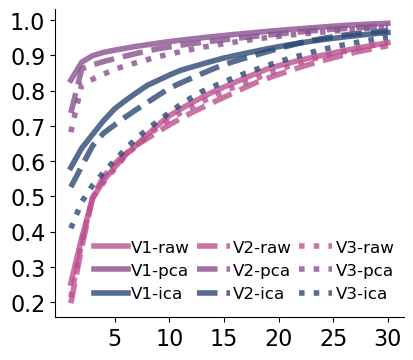

In [74]:
linestyles = ['-', '--', 'dotted']
colors = [ "#bc5090","#8a508f", "#2c4875"]
rois = ['V1', 'V2', 'V3']
axes = ['raw', 'pca', 'ica']
plt.figure(figsize=(4.5,4))
for roi in rois:
    for axis in axes:
        raw_v1 = np.abs(np.mean(np.array(axes_weights[axis][roi]), axis=0))**2
        raw_v1 = (np.sort(raw_v1)[::-1]) / np.sum(raw_v1)
        cumsum_raw_v1 = np.cumsum(raw_v1)[0:30]
        
        plt.plot(cumsum_raw_v1, label = f'{roi}-{axis}', lw=4, alpha=0.8,ls=linestyles[rois.index(roi)], color=colors[axes.index(axis)])
plt.legend(ncol=3, prop={'size': 12}, bbox_to_anchor=(0.07, 0.30), frameon=False,handletextpad=0.2, columnspacing=0.4)
plt.xticks([4,9,14,19,24,29], [5,10,15,20, 25, 30], fontsize=16)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=16)
layer = 'conv2'
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-all_accumulating-ev.svg'), format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

# raw_v2 = np.mean(np.array(axes_weights['raw']['V2']), axis=0)

<ipython-input-15-7bcaed1cb1a9>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(draw_tickslabels)


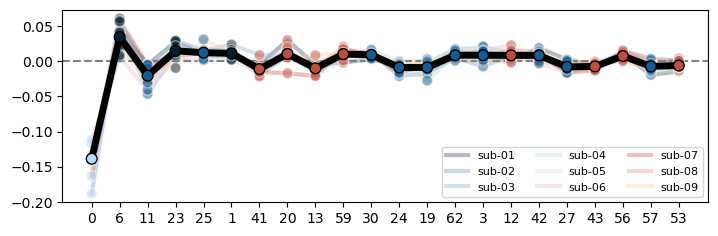

In [15]:
# 只挑出显著的特征，看看单ROI的情况
nodroi_models = {}
rois = ['V1', 'V2', 'V3']
layer = 'conv2'
space = 'pca'
# 加载模型
if layer != 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel')
elif layer == 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel_feature-preprocessed')

if space == 'raw':
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if layer in _])
elif space != 'raw':
    nod_model_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}')
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if 'conv2' in _])
# 加载模型参数
nodroi_weights = {}
for roi in rois:
    nodroi_weights[roi] = [joblib.load(roi_model).coef_ for roi_model in nodroi_models[roi]]
    
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
weights = nodroi_weights['V1']

# 数据准备
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
sub_betas[:, 0:len(weights[0])] = np.array(weights)
sub_betas = sub_betas[:, np.array(draw_sorting)]
_, p_value = stats.ttest_1samp(sub_betas, 0)
mean_betas = sub_betas.mean(axis=0)
# 挑出显著的特征
sigidx = np.where(p_value < 0.05)[0] # np.where(fdr_corrected[0]==True)[0] # 
select_sorting = np.array(draw_sorting)[sigidx]
select_colors = np.array(draw_colors)[sigidx]
sub_betas = sub_betas[:,sigidx]
mean_betas = mean_betas[sigidx]

abs_mean_betas = np.abs(mean_betas)
sorted_indices = np.flip(np.argsort(abs_mean_betas))
sorted_mean_betas = mean_betas[sorted_indices]
sorted_sub_betas = sub_betas[:, sorted_indices]
sorted_draw_sorting = np.array(select_sorting)[sorted_indices]
sorted_draw_colors = np.array(select_colors)[sorted_indices]

num_feature = len(sigidx)
# 只挑出显著的特征，看看单ROI的情况

# 画个大图试试
plt.style.use('default')
scale_factor = 1.2
fig, ax = plt.subplots(1, 1, figsize=(10/scale_factor,3/scale_factor))
# plots
for isub in range(sorted_sub_betas.shape[0]):
    ax.plot(sorted_sub_betas[isub], color=subcolors[isub], lw=3, alpha=0.4, label=f'sub-0{isub+1}')
    ax.scatter(np.arange(len(sorted_draw_sorting)), sorted_sub_betas[isub], color=sorted_draw_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.legend(ncol=3, fontsize=8)
ax.plot(sorted_mean_betas, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(sorted_draw_sorting)), sorted_mean_betas, color=sorted_draw_colors, s=60, edgecolors='black', zorder=5)
# ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

# from scipy import stats
# _, p_value = stats.ttest_1samp(sorted_sub_betas, 0)
# for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
#     infotxt = '*'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='left', verticalalignment='center', zorder=7)
# for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
#     infotxt = '**'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='left', verticalalignment='center',zorder=7)
# for pos in np.where(p_value < 0.001)[0]:
#     infotxt = '***'
#     ax.text(pos+0.08, sorted_mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
#     horizontalalignment='left', verticalalignment='center',zorder=7)
# ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.set_xticks(np.arange(num_feature))
ax.set_xticklabels(sorted_draw_sorting)

plt.show()

In [ ]:
plt.hist()

## 分析六、显著成分轴的最优刺激生成 与 简单特征调制的估计

### 结果 6：参考结果四

## 分析七、同一特征空间中各脑区调制的差异

##### 准备模型系数

In [11]:
nodroi_models = {}
rois = ['V1', 'V2', 'V3']
layer = 'conv2'
space = 'pca'
# 加载模型
if layer != 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel')
elif layer == 'maxpool1':
    nod_model_path = pjoin(work_dir, 'build/roi-concatemodel_feature-preprocessed')

if space == 'raw':
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if layer in _])
elif space != 'raw':
    nod_model_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}')
    for roi in rois:
        nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if 'conv2' in _])
# 加载模型参数
nodroi_weights = {}
for roi in rois:
    nodroi_weights[roi] = [joblib.load(roi_model).coef_ for roi_model in nodroi_models[roi]]

### 结果 7.1：均调制上考察：同一特征空间（conv1 conv2 conv3 conv2-pc conv2-ic）下ROI特征偏好轴的cos距离矩阵

In [3]:
#path setting
roi_concatemodel_path = pjoin(work_dir, 'build/roi-concatemodel')
#params setting
layername = 'googlenet-conv2'
layer_info = {'googlenet-maxpool1':64,
              'googlenet-conv2':63, 
              'googlenet-maxpool2': 192}
channel_num = layer_info[layername]
subs = [f'sub-{isub:02d}' for isub in range(1, 10)]
sub = subs[8]
rois = ['V1', 'V2', 'V3']

单被试分析

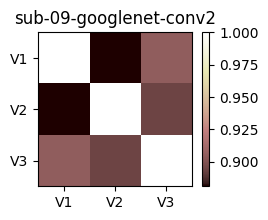

In [162]:
#加载每个roi的模型权重
roi_models = np.nan * np.zeros((3, channel_num))
for iroi, roi in enumerate(rois):
    model = load(pjoin(roi_concatemodel_path, roi, f'{sub}_layer-{layername}_{roi}-linear.pkl'))
    roi_models[iroi, :] = model.coef_

#根据模型权重绘制cos距离矩阵图
#准备cos距离矩阵
roi_models = zscore(roi_models, axis=1)
cosdistance_matrix = np.nan * np.zeros((3, 3))
for i in range(3):
    seed_weights = roi_models[i, :]
    for j in range(3):
        target_weights = roi_models[j, :]
        cosdistance = np.corrcoef(seed_weights, target_weights)[0, 1]
        cosdistance_matrix[i, j] = cosdistance
#绘图
plt.figure(figsize=(5/2, 4/2))
# mesh = plt.pcolormesh(np.flipud(cosdistance_matrix), cmap='jet', edgecolors='k', linewidth=1,vmin=np.nanmin(cosdistance_matrix),vmax=np.nanmax(cosdistance_matrix))
plt.imshow(cosdistance_matrix, cmap='pink', interpolation='nearest', vmin=np.nanmin(cosdistance_matrix), vmax=np.nanmax(cosdistance_matrix))
plt.gcf().set_facecolor('white')
plt.title(f'{sub}-{layername}')
plt.xticks([0 ,1 ,2 ],['V1', 'V2', 'V3'])
plt.yticks([0, 1, 2], ['V1', 'V2', 'V3'])
plt.colorbar()

组平均结果

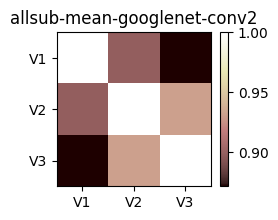

In [168]:
#加载每个roi的模型权重
allsub_matrix = np.nan * np.zeros((len(subs), 3, 3))
for isub , sub in enumerate(subs):
    roi_models = np.nan * np.zeros((3, channel_num))
    for iroi, roi in enumerate(rois):
        model = load(pjoin(roi_concatemodel_path, roi, f'{sub}_layer-{layername}_{roi}-linear.pkl'))
        roi_models[iroi, :] = model.coef_

    #根据模型权重绘制cos距离矩阵图
    #准备cos距离矩阵
    roi_models = zscore(roi_models, axis=1)
    cosdistance_matrix = np.nan * np.zeros((3, 3))
    for i in range(3):
        seed_weights = roi_models[i, :]
        for j in range(3):
            target_weights = roi_models[j, :]
            cosdistance = np.corrcoef(seed_weights, target_weights)[0, 1]
            cosdistance_matrix[i, j] = cosdistance

    allsub_matrix[isub, :, :] = cosdistance_matrix

mean_matrix = np.nanmean(allsub_matrix, axis=0)
#绘图
plt.figure(figsize=(5/2, 4/2))
# mesh = plt.pcolormesh(np.flipud(mean_matrix), cmap='jet', edgecolors='k', linewidth=1,vmin=np.nanmin(mean_matrix),vmax=np.nanmax(mean_matrix))
plt.imshow(mean_matrix, cmap='pink', interpolation='nearest', vmin=np.nanmin(mean_matrix), vmax=np.nanmax(mean_matrix))
plt.gcf().set_facecolor('white')
plt.title(f'allsub-mean-{layername}')
plt.xticks([0 ,1 ,2 ],['V1', 'V2', 'V3'])
plt.yticks([0, 1, 2], ['V1', 'V2', 'V3'])
plt.colorbar()

### 结果 7.2 PC空间前6维和后53维在ROI间的cos距离

In [85]:
#path setting
pca_concatemodel_path = pjoin(work_dir, 'build/roi-concatemodel_feature-pca')
#params setting
layername = 'googlenet-conv2'
subs = [f'sub-{isub:02d}' for isub in range(1, 10)]
sub = subs[2]
rois = ['V1', 'V2', 'V3']

In [132]:
#加载每个roi的模型权重-前6个维度
allsub_matrix1 = np.nan * np.zeros((len(subs), 3, 3))
for isub , sub in enumerate(subs):
    roi_models = np.nan * np.zeros((3, 6))
    for iroi, roi in enumerate(rois):
        model = load(pjoin(pca_concatemodel_path, roi, f'{sub}_layer-{layername}_{roi}-linear.pkl'))
        roi_models[iroi, :] = model.coef_[0:6]

    #根据模型权重绘制cos距离矩阵图
    #准备cos距离矩阵
    roi_models = zscore(roi_models, axis=1)
    cosdistance_matrix = np.nan * np.zeros((3, 3))
    for i in range(3):
        seed_weights = roi_models[i, :]
        for j in range(3):
            target_weights = roi_models[j, :]
            cosdistance = np.corrcoef(seed_weights, target_weights)[0, 1]
            cosdistance_matrix[i, j] = cosdistance

    allsub_matrix1[isub, :, :] = cosdistance_matrix

mean_matrix1 = np.nanmean(allsub_matrix1, axis=0)

In [ ]:
#加载每个roi的模型权重-后57个维度
allsub_matrix2 = np.nan * np.zeros((len(subs), 3, 3))
for isub , sub in enumerate(subs):
    roi_models = np.nan * np.zeros((3, 57))
    for iroi, roi in enumerate(rois):
        model = load(pjoin(pca_concatemodel_path, roi, f'{sub}_layer-{layername}_{roi}-linear.pkl'))
        roi_models[iroi, :] = model.coef_[6 :]

    #根据模型权重绘制cos距离矩阵图
    #准备cos距离矩阵
    roi_models = zscore(roi_models, axis=1)
    cosdistance_matrix = np.nan * np.zeros((3, 3))
    for i in range(3):
        seed_weights = roi_models[i, :]
        for j in range(3):
            target_weights = roi_models[j, :]
            cosdistance = np.corrcoef(seed_weights, target_weights)[0, 1]
            cosdistance_matrix[i, j] = cosdistance

    allsub_matrix2[isub, :, :] = cosdistance_matrix

mean_matrix2 = np.nanmean(allsub_matrix2, axis=0)

In [22]:
v1sig = np.array([ 0,  6,  3, 59, 20, 23, 13, 30, 11, 43, 56,  1, 57, 42, 27, 62, 53, 48, 54])
v2sig = np.array([ 0,  6,  1, 23,  3, 59, 27, 13, 20, 43, 11, 30, 56, 57, 16, 22, 44, 62, 42, 54, 61, 48, 50, 12, 34, 53])
v3sig = np.array([ 0,  6, 11, 23, 25,  1, 41, 20, 13, 59, 30, 24, 19, 62,  3, 12, 42, 27, 43, 56, 57, 53])
intersectionfeatures = np.array(list(set(v1sig.tolist()) & set(v2sig.tolist()) & set(v3sig.tolist())))
otherfeatures = np.delete(np.arange(63), intersectionfeatures)
print(len(intersectionfeatures), len(otherfeatures))
print((intersectionfeatures),'\n',(otherfeatures))

# np.save(pjoin(work_dir, f"build/roi-concatemodel_feature-pca/hierarchicalnewtuning/submean-hierarchy-sig-0.npy"), intersectionfeatures)
# np.save(pjoin(work_dir, f"build/roi-concatemodel_feature-pca/hierarchicalnewtuning/submean-hierarchy-others-0.npy"), otherfeatures)

17 46
[ 0  1  3  6 59 42 11 43 13 20 53 62 23 56 57 27 30] 
 [ 2  4  5  7  8  9 10 12 14 15 16 17 18 19 21 22 24 25 26 28 29 31 32 33
 34 35 36 37 38 39 40 41 44 45 46 47 48 49 50 51 52 54 55 58 60 61]


In [87]:
#加载每个roi的模型权重-显著维度
allsub_matrix1 = np.nan * np.zeros((len(subs), 3, 3))
for isub , sub in enumerate(subs):
    roi_models = np.nan * np.zeros((3, len(intersectionfeatures)))
    for iroi, roi in enumerate(rois):
        model = load(pjoin(pca_concatemodel_path, roi, f'{sub}_layer-{layername}_{roi}-linear.pkl'))
        roi_models[iroi, :] = model.coef_[intersectionfeatures]

    #根据模型权重绘制cos距离矩阵图
    #准备cos距离矩阵
    roi_models = zscore(roi_models, axis=1)
    cosdistance_matrix = np.nan * np.zeros((3, 3))
    for i in range(3):
        seed_weights = roi_models[i, :]
        for j in range(3):
            target_weights = roi_models[j, :]
            cosdistance = np.corrcoef(seed_weights, target_weights)[0, 1]
            cosdistance_matrix[i, j] = cosdistance

    allsub_matrix1[isub, :, :] = cosdistance_matrix

mean_matrix1 = np.nanmean(allsub_matrix1, axis=0)

In [88]:
#加载每个roi的模型权重-其他维度
allsub_matrix2 = np.nan * np.zeros((len(subs), 3, 3))
for isub , sub in enumerate(subs):
    roi_models = np.nan * np.zeros((3, len(otherfeatures)))
    for iroi, roi in enumerate(rois):
        model = load(pjoin(pca_concatemodel_path, roi, f'{sub}_layer-{layername}_{roi}-linear.pkl'))
        roi_models[iroi, :] = model.coef_[otherfeatures]

    #根据模型权重绘制cos距离矩阵图
    #准备cos距离矩阵
    roi_models = zscore(roi_models, axis=1)
    cosdistance_matrix = np.nan * np.zeros((3, 3))
    for i in range(3):
        seed_weights = roi_models[i, :]
        for j in range(3):
            target_weights = roi_models[j, :]
            cosdistance = np.corrcoef(seed_weights, target_weights)[0, 1]
            cosdistance_matrix[i, j] = cosdistance

    allsub_matrix2[isub, :, :] = cosdistance_matrix

mean_matrix2 = np.nanmean(allsub_matrix2, axis=0)

绘图

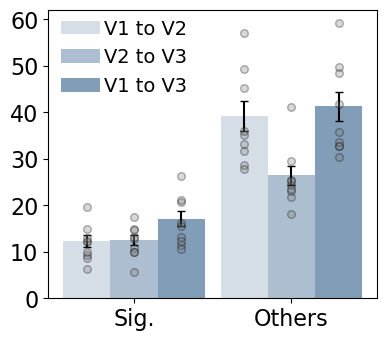

In [105]:
cos2degree = lambda x : np.degrees(np.arccos(np.abs(x)))
mean_data = np.array([[mean_matrix1[0,1], mean_matrix1[1, 2], mean_matrix1[0, 2]],
                 [mean_matrix2[0,1], mean_matrix2[1, 2], mean_matrix2[0, 2]]])

allsub_data = np.zeros((2, 9, 3))
for i in range(8):
    allsub_data[0, :,0] = allsub_matrix1[:, 0, 1]
    allsub_data[0, :,1] = allsub_matrix1[:, 1, 2]
    allsub_data[0, :,2] = allsub_matrix1[:, 0, 2]

    allsub_data[1, :,0] = allsub_matrix2[:, 0, 1]
    allsub_data[1, :,1] = allsub_matrix2[:, 1, 2]
    allsub_data[1, :,2] = allsub_matrix2[:, 0, 2]

# sems = np.std(allsub_data, axis=1) / np.sqrt(allsub_data.shape[1])
sems = np.std(cos2degree(allsub_data), axis=1) / np.sqrt(allsub_data.shape[1])

lables = ['V1 to V2', 'V2 to V3', 'V1 to V3']
colors = ["#d1dbe4","#a3b7ca","#7593af"]

scale = 0.8
fig, ax = plt.subplots(figsize=(3.4/scale,3/scale))
bar_width = 0.3
group_indices = np.arange(2)

for i in range(3):
    rects = ax.bar(group_indices + i * bar_width, cos2degree(mean_data[:, i]), bar_width, label=lables[i], 
    yerr=sems[:, i],capsize=3, color=colors[i], alpha=0.9)
    for j in range(2):
        for k in range(9):
            data = cos2degree(allsub_data[j, k, i])
            ax.scatter(group_indices[j] + i*bar_width, data, color='grey', s=30, 
                       edgecolor='black', linewidth=1., alpha=0.3, zorder=3)


# ax.set_ylim( [0.48,1])
ax.legend( bbox_to_anchor=(0.01, 1), loc='upper left', ncol=1, frameon=False, fontsize=14,handletextpad=0.2, labelspacing=0.5, borderaxespad=0.1)
plt.xticks([0.3, 1.3], ['Sig.', 'Others'], fontsize=16)
plt.yticks(fontsize=16)
plt.gcf().set_facecolor('white')
layer = 'conv2'
space = 'pca'
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{space}_suspace-distance.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)

In [75]:
from scipy import stats


t_stat, p_value = stats.ttest_rel(allsub_data[1][:, 1], allsub_data[1][:, 2])
# 输出结果
print(f'T统计量: {t_stat}')
print(f'P值: {p_value}')

T统计量: 3.5793437657783294
P值: 0.007195138415924963


In [40]:
data = cos2degree(allsub_data)
np.std(data, axis=1) / 

array([[3.68042736, 3.28361997, 5.00168037],
       [9.4666536 , 6.15359984, 9.36677326]])

### 结果7.3 平均调制的分析：ROI间的正交新特征

In [12]:
#path setting
space = 'pca'
pca_concatemodel_path = pjoin(work_dir, f'build/roi-concatemodel_feature-{space}/subtuning')
#params setting
layername = 'googlenet-conv2'
subs = [f'sub-{isub:02d}' for isub in range(1, 10)]
# sub = subs[2]
rois = ['V1', 'V2', 'V3']
#
roi_allsub_tuning = []
for roi in rois:
    allsubtuning = np.load(pjoin(pca_concatemodel_path, f'allsub_{roi}-tuning.npy'), allow_pickle=True).item()
    allsubtuning = np.array(list(allsubtuning.values()))
    roi_allsub_tuning.append(allsubtuning)
roi_allsub_tuning = np.array(roi_allsub_tuning)

In [20]:
roi_allsub_tuning[0,-1,0:7],roi_allsub_tuning[1,-1,0:7],roi_allsub_tuning[2,-1,0:7]

(array([-0.13868735,  0.01119693,  0.00368137,  0.00841645, -0.00364475,
        -0.00049237,  0.03448122]),
 array([-0.1259133 ,  0.01561075,  0.00190422,  0.01308515, -0.00293675,
         0.0032447 ,  0.05193828]),
 array([-0.08359083,  0.00731418,  0.00156936,  0.01228855, -0.00389683,
         0.00507544,  0.03726542]))

In [43]:
roi_mean_tuning = roi_allsub_tuning[:,-1,:]

np.round(np.degrees(np.arccos(np.corrcoef(zscore(roi_mean_tuning, axis=1)))), decimals=1)

array([[ 0. , 14.9, 18.1],
       [14.9,  0. ,  9.3],
       [18.1,  9.3,  0. ]])

In [44]:
np.array([np.round(np.degrees(np.arccos(np.corrcoef(zscore(roi_allsub_tuning[:,_,:], axis=1)))), decimals=1) for _ in range(9)]).mean(axis=0)

array([[ 0.        , 19.46666667, 25.86666667],
       [19.46666667,  0.        , 18.26666667],
       [25.86666667, 18.26666667,  0.        ]])

In [62]:
func = lambda x :np.round(np.degrees(np.arccos(np.corrcoef(zscore(x, axis=1)))), decimals=1)
func = lambda x :(np.arccos(np.corrcoef(zscore(x, axis=1))))
all_data = np.array([func(roi_allsub_tuning[:,_,:]) for _ in range(9)])
sample_data = all_data[:,0,2]
print(sample_data)
t_stat, p_value = stats.ttest_1samp(sample_data, 0)

# 输出结果
print(f'T统计量: {t_stat}')
print(f'P值: {p_value}')

[0.37305253 0.3182061  0.38038574 0.43702385 0.69240737 0.46649753
 0.40847622 0.48364533 0.50404892]
T统计量: 12.557020941193896
P值: 1.516058247624095e-06


In [70]:
# 现在我们有一个 V1
newtype = 'others'#'sig'#'all'
axisnum = len(otherfeatures)#len(intersectionfeatures)#63
roi_mean_tuning = roi_allsub_tuning[:, -1, otherfeatures]#intersectionfeatures
v1_vec, v2_vec, v3_vec = roi_mean_tuning[0], roi_mean_tuning[1], roi_mean_tuning[2]
dv2v1 = v2_vec - np.dot(v1_vec / np.sqrt(np.sum(v1_vec**2)),v2_vec) * v1_vec / np.sqrt(np.sum(v1_vec**2))
dv3v2 = v3_vec - np.dot(v3_vec,v2_vec / np.sqrt(np.sum(v2_vec**2))) * v2_vec / np.sqrt(np.sum(v2_vec**2))
dv3v1 = v3_vec - np.dot(v3_vec,v1_vec / np.sqrt(np.sum(v1_vec**2))) * v1_vec / np.sqrt(np.sum(v1_vec**2))
new_tuning = {}
new_tuning[f'sub-mean-dv2v1-{newtype}-{axisnum}'] = dv2v1 / np.linalg.norm(dv2v1)
new_tuning[f'sub-mean-dv3v2-{newtype}-{axisnum}'] = dv3v2 / np.linalg.norm(dv3v2)
new_tuning[f'sub-mean-dv3v1-{newtype}-{axisnum}'] = dv3v1 / np.linalg.norm(dv3v1)
np.save(pjoin(work_dir, f"build/roi-concatemodel_feature-pca/hierarchicalnewtuning/submean-hierarchy-{newtype}-{axisnum}.npy"), new_tuning)


In [56]:
np.linalg.norm(dv2v1)

0.04163915308476232

In [24]:
roi_mean_tuning = roi_allsub_tuning[:, -1, intersectionfeatures]
v1_vec, v2_vec, v3_vec = roi_mean_tuning[0], roi_mean_tuning[1], roi_mean_tuning[2]
np.dot(v1_vec,v2_vec) * v1_vec / np.sqrt(np.sum(v1_vec**2))

array([-0.01951418,  0.00157548,  0.00118425,  0.00485172,  0.00142074,
        0.00115283, -0.0028932 , -0.00105482, -0.00142436,  0.00145644,
       -0.00087253,  0.00119277,  0.00207734,  0.00104258, -0.00104228,
       -0.00114371,  0.0012719 ])

In [47]:
v2_vec - np.dot(v1_vec/np.sqrt(np.sum(v1_vec**2)),v2_vec) * v1_vec / np.sqrt(np.sum(v1_vec**2))

array([ 5.46367463e-03,  5.00401716e-03,  5.11233965e-03,  1.92745986e-02,
        3.17844552e-03,  1.24690825e-04,  9.34459841e-03, -3.30330388e-03,
       -2.73997245e-03,  1.82545616e-03,  4.85397290e-04,  1.78363932e-05,
        2.49039608e-04,  2.23122358e-03, -1.93594513e-03, -4.93627170e-03,
        1.09428201e-03])

In [46]:
v1_norm = np.linalg.norm(v1_vec)
v1_unit = v1_vec / v1_norm
proj_v2_on_v1 = np.dot(v2_vec, v1_unit) * v1_unit
perp_v2_to_v1 = v2_vec - proj_v2_on_v1
perp_v2_to_v1/ np.sqrt(np.sum(perp_v2_to_v1**2))

array([ 2.21888462e-01,  2.03221046e-01,  2.07620193e-01,  7.82771914e-01,
        1.29081696e-01,  5.06389149e-03,  3.79498910e-01, -1.34152391e-01,
       -1.11274612e-01,  7.41346597e-02,  1.97127511e-02,  7.24364119e-04,
        1.01138921e-02,  9.06135158e-02, -7.86217913e-02, -2.00469796e-01,
        4.44405217e-02])

In [38]:
sint_v2 = v2_vec * np.sin(np.arccos(np.dot(v1_vec,v2_vec)/ (np.sqrt(np.sum(v1_vec**2)) * np.sqrt(np.sum(v2_vec**2)))))
sint_v2 /  np.sqrt(np.sum(sint_v2**2))

array([-0.88147077,  0.10928485,  0.09160412,  0.36359996,  0.08921199,
        0.05520674, -0.07094092, -0.07283996, -0.0863128 ,  0.08142246,
       -0.03772521,  0.05634123,  0.09965026,  0.06475762, -0.06267614,
       -0.0884609 ,  0.06760645])

In [26]:
intersectionfeatures

array([ 0,  1,  3,  6, 59, 42, 11, 43, 13, 20, 53, 62, 23, 56, 57, 27, 30])

In [73]:
# 比较新轴与PCA轴的关系
distances = {'dv2v1': np.zeros((9, 63)), 'dv3v2': np.zeros((9, 63))}
feature_path = pjoin(work_dir, 'prep/image_activations/pca/vectors')
pcavectors = np.squeeze(np.load(pjoin(feature_path, 'nodstimeigenvectors-64.npy')))
subspace = 'Sig.'
for isub, sub in enumerate(subs):
    roi_mean_tuning = roi_allsub_tuning[:, isub, otherfeatures]#intersectionfeatures#
    v1_vec, v2_vec, v3_vec = roi_mean_tuning[0], roi_mean_tuning[1], roi_mean_tuning[2]
    dv2v1 = v2_vec - np.dot(v1_vec/ np.sqrt(np.sum(v1_vec**2)),v2_vec) * v1_vec / np.sqrt(np.sum(v1_vec**2))
    dv3v2 = v3_vec - np.dot(v3_vec,v2_vec/ np.sqrt(np.sum(v2_vec**2))) * v2_vec / np.sqrt(np.sum(v2_vec**2))
    dv3v1 = v3_vec - np.dot(v3_vec,v1_vec/ np.sqrt(np.sum(v1_vec**2))) * v1_vec / np.sqrt(np.sum(v1_vec**2))
    # 当前在PC空间需要转回去在做比较
    dvv_raw = np.squeeze(np.dot(pcavectors[:, otherfeatures], dv3v2[:,None]))#intersectionfeatures
    distances['dv3v2'][isub, :] = np.array([(np.abs(np.corrcoef(zscore(dvv_raw), zscore(pcavectors[:,_]))))[0,1] for _ in range(63)])
    dvv_raw = np.squeeze(np.dot(pcavectors[:, otherfeatures], dv2v1[:,None]))#intersectionfeatures
    distances['dv2v1'][isub, :] = np.array([(np.abs(np.corrcoef(zscore(dvv_raw), zscore(pcavectors[:,_]))))[0,1] for _ in range(63)])

In [69]:
np.degrees(np.arccos(np.corrcoef(zscore(dv2v1), zscore(dv3v2))))

array([[ 0.        , 81.66265245],
       [81.66265245,  0.        ]])

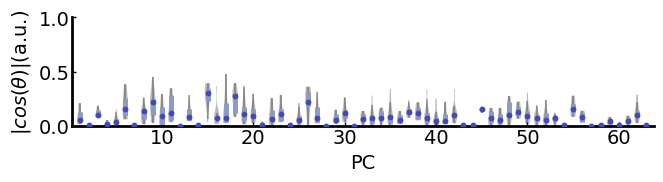

In [75]:

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
plt.style.use('default')
scale = 0.8
fig,ax = plt.subplots(figsize=(6/scale,9/8/scale))
# fig,ax = plt.subplots(figsize=(1.5,1.5))
width=0.6
font_size = 14
# load data
newtuning = 'dv2v1'
draw_index =  distances[newtuning].T
index_name =  r'|$cos(\theta)$|(a.u.)'

# draw for each subject
for i, data in enumerate(draw_index) :
    parts = ax.violinplot(data, positions=[i], widths=width,showextrema=False,showmedians=False, vert=True)
    for pc in parts['bodies']:
        pc.set_facecolor('gray')##81C6E8
        pc.set_alpha(0.55)
    q1, medians, q3 = np.percentile(np.sort(data), [25, 50, 75], axis=0)
    whiskers = np.array([adjacent_values(np.sort(data), q1, q3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    ax.scatter(i, medians, marker='o', color='#4448bd', s=10, zorder=3)#'black'
    ax.vlines(i, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1.2, alpha=0.3)
    ax.vlines(i, q1, q3, color='red',edgecolors='#8d9bc3', linestyle='-', lw=3.6)
#E97777
ax.set_xlim([-0.8,62.8])

ax.set_ylim([0,1.])
# ax.set_ylim([0,.8])
ax.set_xlabel(f'PC',fontsize=font_size)
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels([],fontsize=10.5)
# ax.set_ylim([0,1.85])
ax.set_xticks([9,19,29,39,49,59])
ax.set_xticklabels([10,20,30,40,50,60])
ax.set_ylabel(index_name, fontsize=font_size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.tick_params(labelsize=font_size, width=1, length=3, direction="in", pad=2)
plt.savefig(pjoin(res_fig_dir, f'layer-{layer}_space-{subspace}-{space}_{newtuning}_newtuning-distance.svg'), format='svg', bbox_inches='tight', pad_inches=0.01)
# fig.savefig(pjoin(fig_path, f'{index_name}-{taskname}.jpg'),dpi=72*4,bbox_inches='tight')
plt.show()

In [59]:
pjoin(res_fig_dir, f'layer-{layer}_space-{subspace}-{space}_{newtuning}_newtuning-distance.svg'),

('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/vis/results_plots/layer-conv2_space-Sig.-pca_dv3v2_newtuning-distance.svg',)

In [65]:
dv2v1_raw = np.squeeze(np.dot(pcavectors[:,:], dv2v1[:,None]))

np.argsort([np.degrees(np.arccos(np.abs(np.corrcoef(zscore(dv2v1_raw), zscore(pcavectors[:,_])))))[0,1] for _ in range(63)])

array([ 0,  6,  3, 12, 29,  5, 13, 59, 43, 26, 19, 61, 17,  1, 15, 27, 10,
       30, 48, 39, 34, 42, 36, 22,  9, 56, 23, 40, 32, 54, 11, 44,  7, 41,
       46, 58, 25, 35, 33, 16, 37, 28, 51, 47, 38, 21, 18, 14, 52, 45, 49,
       53, 62, 55, 57, 50,  4,  8, 24, 31, 60,  2, 20])

In [64]:
np.sort([np.degrees(np.arccos(np.abs(np.corrcoef(zscore(dv2v1_raw), zscore(pcavectors[:,_])))))[0,1] for _ in range(63)])

array([38.59195021, 60.14029585, 75.88932309, 79.33920377, 79.77197408,
       80.10048103, 80.60443631, 81.61785302, 82.37409589, 82.63743985,
       82.72631402, 82.73706434, 83.15823949, 84.30700235, 84.41257859,
       84.57258778, 84.62537229, 84.83349907, 84.87403965, 85.00024247,
       85.23970738, 85.45429183, 85.52360004, 85.82313865, 86.00582621,
       86.04179472, 86.40032472, 86.47676383, 86.57999343, 86.5872637 ,
       86.82130781, 86.96549845, 87.01487429, 87.33721944, 87.41314959,
       87.50963964, 87.64092057, 87.65241914, 87.85154046, 87.878509  ,
       87.93980528, 87.94453803, 87.97764487, 87.98921434, 88.18309825,
       88.29053362, 88.39287566, 88.41999951, 88.67914391, 88.71732488,
       88.83988888, 88.98689426, 89.00626501, 89.17050679, 89.23098135,
       89.25588155, 89.27792458, 89.35563168, 89.51608202, 89.72502566,
       89.75521244, 89.86567303, 89.96134745])

In [70]:
np.round(dv3v1 / np.sqrt(np.sum(dv3v1**2)), decimals=1)

array([ 0.7,  0.1,  0.1,  0.1, -0.1, -0.2, -0. , -0.2,  0.1, -0.2, -0.1,
        0. , -0.1,  0. ,  0.2, -0. ,  0.1,  0.2, -0.1,  0.1, -0.1, -0.1,
        0. ,  0.2,  0.2, -0. , -0.1,  0. , -0.1,  0. ,  0.1,  0. ,  0. ,
       -0. , -0. , -0.1,  0.1, -0.1, -0.1, -0.1,  0. , -0.1, -0.1,  0. ,
        0. ,  0. , -0. , -0.1,  0.1,  0. ,  0.1, -0.1, -0.1,  0.2, -0.1,
        0.1,  0.1])

### 结果7.4：体素调制上考察：roi内所有体素特征偏好轴做PCA，比较ROI间80%所有成分数

In [4]:
#路径设置
work_dir = '/nfs/z1/userhome/zzl-xsk/Featurespace'
cifti_path = '/nfs/z1/userhome/zzl-xsk/NOD/derivatives/ciftify'
masked_retino_path = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel')
pca_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-pca')
ica_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-ica')
concate_path = pjoin(work_dir, 'prep/roi-concate')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
#参数设置
subs = [f'sub-{isub:02d}' for isub in range(1, 10)]
layername = 'googlenet-conv2'
roiname = 'V1'

In [ ]:
# 单被试的PC


In [23]:
# 所有被试 pc 求平均
from sklearn.decomposition import PCA
mean_axes = []

roinames = ['V1', 'V2', 'V3']

for isub, sub in enumerate(subs):
    allsub_axis = np.nan * np.zeros((9, 3, 63))
    allsub_allroi_cumsumev = np.nan * np.zeros((9, 3, 63))
    for iroi, roiname in enumerate(roinames):
        #读取被试的tuning
        voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))#[:, channels]
        #读取体素信息
        voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
        pca = PCA(n_components=63)
        pca.fit(voxelwise_model)
        cumlative_variance = np.cumsum(pca.explained_variance_ratio_)
        allsub_allroi_cumsumev[isub, iroi, :] = cumlative_variance
        allsub_axis[isub, iroi, :] = pca.components_[0]

    mean_cumsumev = np.nanmean(allsub_allroi_cumsumev, axis=0)
    mean_axes.append( np.nanmean(allsub_axis, axis=0))

In [11]:
from sklearn.decomposition import PCA
mean_axes = []

roinames = ['V1', 'V2', 'V3']

ncomp = 6
allsub_axis = np.nan * np.zeros((ncomp, 9, 3, 63))
for icomp in range(ncomp):
    for isub, sub in enumerate(subs):
        allsub_allroi_cumsumev = np.nan * np.zeros((9, 3, 63))
        for iroi, roiname in enumerate(roinames):
            #读取被试的tuning
            voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))#[:, channels]
            # voxelwise_model_perf = np.load()
            #读取体素信息
            voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
            pca = PCA(n_components=63)
            pca.fit(voxelwise_model)
            cumlative_variance = np.cumsum(pca.explained_variance_ratio_)
            allsub_allroi_cumsumev[isub, iroi, :] = cumlative_variance
            allsub_axis[icomp, isub, iroi, :] = pca.components_[icomp]


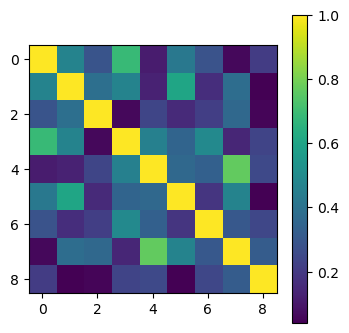

In [18]:
allsub_axis[0,:,0,:].shape
plt.style.use('default')
plt.figure(figsize=(4,4))
plt.imshow(np.abs(np.corrcoef(zscore(allsub_axis[0,:,0,:], axis=1)), ))
plt.colorbar()

In [ ]:
sub_roi_comp = 

In [148]:
np.round(pca.explained_variance_ratio_, decimals=2)

array([0.2 , 0.12, 0.08, 0.07, 0.06, 0.06, 0.05, 0.04, 0.04, 0.03, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

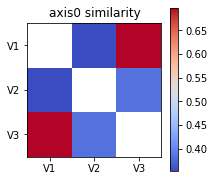

In [8]:
corrmatrix = np.corrcoef(mean_axis)

plt.figure(figsize=(3, 3))
eye = np.eye(3)
eye[eye == 1] = np.nan
plt.imshow(corrmatrix - eye, cmap='coolwarm', interpolation='nearest', vmin=np.nanmin(corrmatrix - eye), vmax=np.nanmax(corrmatrix - eye))
plt.gcf().set_facecolor('white')
plt.title('axis0 similarity')
plt.xticks([0, 1, 2], ['V1', 'V2', 'V3'])
plt.yticks([0, 1, 2], ['V1', 'V2', 'V3'])
plt.colorbar()

In [9]:
corrmatrix

array([[1.        , 0.35153815, 0.69698107],
       [0.35153815, 1.        , 0.382114  ],
       [0.69698107, 0.382114  , 1.        ]])

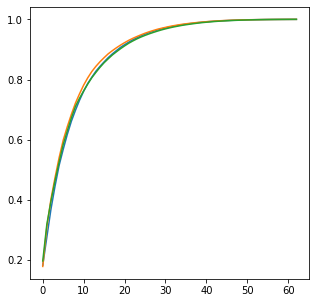

In [75]:
n_comps = np.arange(63)

fig, ax = plt.subplots(figsize=(5, 5))
for i in range(3):
    roidata = mean_cumsumev[i]
    plt.plot(n_comps, roidata, label=roinames[i])

plt.gcf().set_facecolor('white')
plt.show()

### 结果7.5：roi内所有体素聚类分析，（如果有）比较roi间的典型调制的区别

In [2]:
#路径设置
work_dir = '/nfs/z1/userhome/zzl-xsk/Featurespace'
cifti_path = '/nfs/z1/userhome/zzl-xsk/NOD/derivatives/ciftify'
masked_retino_path = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel')
pca_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-pca')
ica_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-ica')
concate_path = pjoin(work_dir, 'prep/roi-concate')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
#参数设置
subs = [f'sub-{isub:02d}' for isub in range(1, 10)]
layername = 'googlenet-conv2'
# roiname = 'V1'

In [52]:
roinames = ['V1', 'V2','V3']
all_weights = []
sub_splitline = np.zeros((3, 10))
roi_splitline = np.zeros((1, 4))
for iroi, roiname in enumerate(roinames):
    for isub, sub in enumerate(subs):
        #读取被试的tuning，并进行标准化
        voxelwise_model = np.load(pjoin(voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))#[:, channels]
        #读取体素信息，并选取ecc小于8的体素
        voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
        # prior_prf = nib.load(pjoin(masked_retino_path, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()
        # ecc_select_voxels = np.where((prior_prf[1, :] <= 8)==True)[0]
        # select_voxels = np.intersect1d(voxels, ecc_select_voxels)
        # select_voxel_idx = np.squeeze([np.where(voxels == i)[0] for i in  select_voxels])
        # voxelwise_model = voxelwise_model[select_voxel_idx, :]
        # sub_voxels = len(select_voxels)
        #添加到体素库中
        all_weights.append(voxelwise_model)
        #记录被试分界线
        sub_splitline[iroi, isub+1] = sub_splitline[iroi, isub] + len(voxels)
    #记录roi分界线
    roi_voxels = sub_splitline[iroi, -1]
    roi_splitline[0, iroi+1] = roi_splitline[0, iroi] + roi_voxels

all_weights = np.concatenate(all_weights, axis=0)
all_weights = zscore(all_weights, axis=1)

肘部法则

/nfs/z1/userhome/zzl-xsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/nfs/z1/userhome/zzl-xsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/nfs/z1/userhome/zzl-xsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/nfs/z1/userhome/zzl-xsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default valu

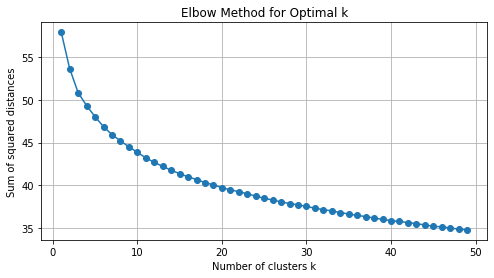

In [76]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sse = []
k_range = range(1, 50)  # 假设我们考虑的聚类数从1到10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(all_weights)
    sse.append(kmeans.inertia_ / all_weights.shape[0])  # inertia_ 是模型的SSE

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

类别间的相似性

/nfs/z1/userhome/zzl-xsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


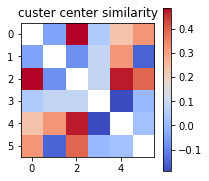

In [79]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

k = 6
kmeans = KMeans(n_clusters=k, random_state=1).fit(all_weights)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

martix = np.corrcoef(cluster_centers)
plt.figure(figsize=(3, 3))
eye = np.eye(6)
eye[eye == 1] = np.nan
plt.imshow(martix - eye, cmap='coolwarm', interpolation='nearest', vmin=np.nanmin(martix - eye), vmax=np.nanmax(martix - eye))
plt.gcf().set_facecolor('white')
plt.title('custer center similarity')
plt.colorbar()

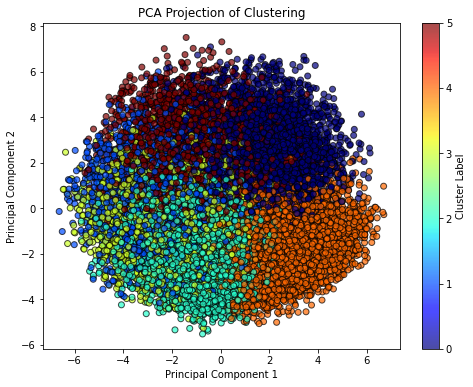

In [57]:
pca = PCA(n_components=2)  # 选择两个主成分
X_pca = pca.fit_transform(all_weights)

# 绘制 PCA 降维后的数据点
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='jet', edgecolor='k', alpha=0.7)
plt.title('PCA Projection of Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.gcf().set_facecolor('white')
plt.show()

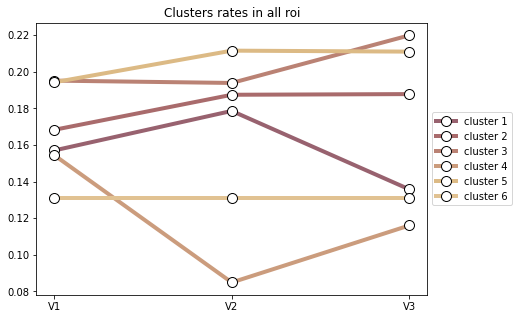

In [80]:
v1_labels = labels[int(roi_splitline[0, 0]) : int(roi_splitline[0, 1])]
v2_labels = labels[int(roi_splitline[0, 1]) : int(roi_splitline[0, 2])]
v3_labels = labels[int(roi_splitline[0, 2]) : int(roi_splitline[0, 3])]

allroi_labels = np.array([[np.sum(v1_labels==0)/ len(v1_labels), np.sum(v1_labels==1)/ len(v1_labels), np.sum(v1_labels==2)/ len(v1_labels), np.sum(v1_labels==3)/ len(v1_labels), np.sum(v1_labels==4)/ len(v1_labels), np.sum(v1_labels==5)/ len(v1_labels)], 
                 [np.sum(v2_labels==0) / len(v2_labels), np.sum(v2_labels==1) / len(v2_labels), np.sum(v2_labels==2) / len(v2_labels), np.sum(v2_labels==3) / len(v2_labels), np.sum(v2_labels==4) / len(v2_labels), np.sum(v1_labels==5)/ len(v1_labels)],
                 [np.sum(v3_labels==0) / len(v3_labels), np.sum(v3_labels==1) / len(v3_labels), np.sum(v3_labels==2) / len(v3_labels), np.sum(v3_labels==3) / len(v3_labels), np.sum(v3_labels==4) / len(v3_labels), np.sum(v1_labels==5)/ len(v1_labels)]])

allsub_labels = np.nan * np.zeros((9, 3, 6))
for isub in range(9):
    subv1_labels = v1_labels[int(sub_splitline[0, isub]) : int(sub_splitline[0, isub + 1])]
    for label in range(6):
        label_rates = np.sum(subv1_labels ==label) / len(subv1_labels)
        allsub_labels[isub, 0, label] = label_rates

    subv2_labels = v2_labels[int(sub_splitline[1, isub]) : int(sub_splitline[1, isub + 1])]
    for label in range(6):
        label_rates = np.sum(subv2_labels ==label) / len(subv2_labels)
        allsub_labels[isub, 1, label] = label_rates

    subv3_labels = v3_labels[int(sub_splitline[2, isub]) : int(sub_splitline[2, isub + 1])]
    for label in range(6):
        label_rates = np.sum(subv3_labels ==label) / len(subv3_labels)
        allsub_labels[isub, 2, label] = label_rates

roi_size = np.array([len(v1_labels), len(v2_labels), len(v3_labels)])
#计算标准误
roi_sems = np.zeros((3, 6))  # 为3个ROI的5个label计算标准误
for iroi in range(3):
    for label in range(5):
        # 提取当前ROI和label的所有被试数据
        label_data = allsub_labels[:, iroi, label]
        # 计算标准差
        std_dev = np.std(label_data, ddof=1)
        # 计算标准误：标准差除以被试的平方根数量
        sem = std_dev / np.sqrt(9)
        roi_sems[iroi, label] = sem

roi_indices = np.arange(3)
bar_width = 0.15
colors = ["#98626f","#a96b6c","#ba8274","#cb9c7d","#dcba85","#e1c292"]
fig, ax = plt.subplots(figsize=(7,5))
for i in range(6):
    roi_data = allroi_labels[:, i]
    roi_sem = roi_sems[:, i] 
    ax.plot(roi_indices, roi_data, label=f'cluster {i+1}', color=colors[i], linewidth=4, marker='.', markersize=20, markeredgecolor='black',markerfacecolor='white')
    # ax.fill_between(roi_indices, roi_data - roi_sem, roi_data + roi_sem, color=colors[i], alpha=0.05)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title('Clusters rates in all roi')
plt.gcf().set_facecolor('white')
plt.xticks([0, 1, 2], ['V1', 'V2', 'V3'])
plt.show()


卡方检验

In [59]:
import numpy as np
from scipy.stats import chi2_contingency

# 创建一个数组，其中包含三个群体在五类人格下的人数
data = allroi_labels * roi_size[:, None]

# 执行卡方检验
chi2, p, dof, expected = chi2_contingency(data)

# 打印结果
print("Chi-square Statistic:", chi2)
print("P-value:", p)


Chi-square Statistic: 45.768025207026184
P-value: 1.5798860953534382e-06


## 分析八、检验模型视网膜拓扑与实验结果

### 结果 8.1：模型与实验上得到的组平均的视网膜拓扑映射图谱

In [8]:
retino_file = nib.load('/nfs/z1/userhome/zzl-xsk/Featurespace/anal/brainmap/masked_retinotopy/nod_new-weighted-dnn-mean-prf.dscalar.nii')
retino_data = retino_file.get_fdata()
#获取param names
param_names = retino_file.header.get_axis(0).name.tolist()
retino_data_dict = {name:retino_data[_,:] for _, name in enumerate(param_names)}
curv_file = '/nfs/z1/userhome/zzl-xsk/Featurespace/anal/brainmap/masked_retinotopy/allsub_mean-curvature.32k_fs_LR.dscalar.nii'
curvature = np.squeeze(nib.load(curv_file).get_fdata())
work_path = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/code/nodanalysis/'
with h5py.File(pjoin(work_path, 'prfresults.mat'),'r') as file:
    print(file.keys())
    # This indexing vector performs a nearest-neighbor mapping 
    # from CIFTI to FreeSurfer's fsaverage space.
    ciftifsaverageix = file['ciftifsaverageix'][:]
    ix = np.squeeze(ciftifsaverageix.astype(np.int64)) - 1

    # logical values indicating which fsaverage vertices 
    # do not have a counterpart in the CIFTI space.
    ciftifsaveragebad = file['ciftifsaveragebad'][:]
    bad_id = np.squeeze(ciftifsaveragebad.astype(np.int64))

# check variables
inspect_var = ciftifsaverageix
inspect_var.shape, np.unique(inspect_var), np.sum(inspect_var)
# r2
r2 = np.squeeze(retino_data_dict['R2'][ix])
r2[np.where(bad_id==1)] = np.nan
# eccentricity
ecc = np.squeeze(retino_data_dict['ecc'][ix]*16/200)
ecc[np.where(bad_id==1)] = np.nan
# polar angle
angle = np.squeeze(retino_data_dict['ang'][ix])
#转换angle坐标
angle = np.squeeze(retino_data_dict['ang'][ix])
# rfsize
size = np.squeeze(retino_data_dict['rfsize'][ix,]*16/200)
size[np.where(bad_id==1)] = np.nan
# curvature
fsa_curvature = curvature[ix]
angle = np.squeeze(retino_data_dict['ang'][ix])

fsaverage = ny.freesurfer_subject('fsaverage')

v1_centers = {}
for h in ['lh', 'rh']:
    # Get the Cortex object for this hemisphere.
    cortex = fsaverage.hemis[h]
    # We're dealing with the cortical sphere, so get that surface.
    sphere = cortex.registrations['native']
    # Grab the V1_weight property and the coordinates.
    v1_weight = sphere.prop('V1_weight')
    coords = sphere.coordinates
    # Now, we can take a weighted average of the coordinates in V1.
    v1_center = np.sum(coords * v1_weight[None,:], axis=1)
    v1_center /= np.sum(v1_weight)
    # Save this in the v1_centers dict.
    v1_centers[h] = v1_center

print(v1_centers)
# # See what got saved:
v1_centers['lh'] = np.array([ 0.79666838, -88.80057563, -54.63788443])
v1_centers['rh'] = np.array([-30.23899003, -75.23617797, -52.21611106])

v1_rights = {}
for h in ['lh', 'rh']:

    cortex = fsaverage.hemis[h]
    # cortex = sub.hemis[h]
    sphere = cortex.registrations['native']

    weight = sphere.prop('cortex_label')

    weight = ~weight
    coords = sphere.coordinates
    mwall_center = np.mean(coords[:, weight], axis=1)
    # If this is the RH, we invert this coordinate
    v1_rights[h] = -mwall_center if h == 'rh' else mwall_center

method = 'orthographic' # or: equirectangular, sinusoidal, mercator
radius = np.pi/3.7

# Now, we make the projections:
map_projs = {}
for h in ['lh', 'rh']: 
    mp = ny.map_projection(chirality=h,
                           center=v1_centers[h],
                           center_right=v1_rights[h],
                           method=method,
                           radius=radius,
                           registration='fsaverage')
    map_projs[h] = mp
flatmaps = {h: mp(fsaverage.hemis[h]) for (h,mp) in map_projs.items()}
# mask
thres_quota_lh = r2[0:163842][flatmaps['lh'].labels]

thres_quota_rh = r2[163842::][flatmaps['rh'].labels]
r2_mask_lh = ~np.isnan(thres_quota_lh)
r2_mask_rh = ~np.isnan(thres_quota_rh)

# underlay
curv = fsa_curvature
underlay_lh = -curv[0:163842][flatmaps['lh'].labels]
underlay_rh = -curv[163842::][flatmaps['rh'].labels]
# file = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/retinoparams/sub-03_layer-features3_params.npy'
file = retino_path
retino_data_dict = {name:retino_data[_,:] for _, name in enumerate(param_names)}
# eccentricity
ecc = np.squeeze(retino_data_dict['ecc'][ix])
ecc[np.where(bad_id==1)] = np.nan

# polar angle
angle = np.squeeze(retino_data_dict['ang'][ix])
angle[np.where(bad_id==1)] = np.nan

# rfsize
size = np.squeeze(retino_data_dict['rfsize'][ix,])
size[np.where(bad_id==1)] = np.nan

# r2
r2 = np.squeeze(retino_data_dict['R2'][ix])
r2[np.where(bad_id==1)] = np.nan
params = [angle, ecc, size, r2]
plot_param = angle

lh_mesh3D_fs_quota = plot_param[0:163842]
flatmap_quota_lh = lh_mesh3D_fs_quota[flatmaps['lh'].labels]

rh_mesh3D_fs_quota = plot_param[163842::]
flatmap_quota_rh = rh_mesh3D_fs_quota[flatmaps['rh'].labels]

<KeysViewHDF5 ['#refs#', 'allresults', 'ciftifsaveragebad', 'ciftifsaverageix', 'groupsubjectids', 'quants', 'subjectids']>
{'lh': array([ 37.79666838, -70.80057563, -54.63788443]), 'rh': array([-60.23899003, -55.23617797, -52.21611106])}


Eccentricity

(-82.44480171457843, 82.49431034456116, -82.45580941531591, 82.44842593569429)

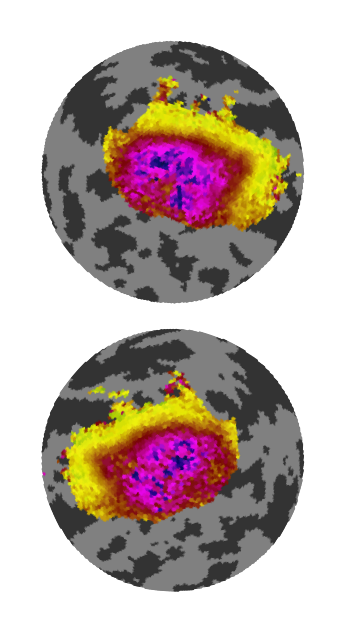

In [22]:
flatmap_quota_lh[flatmap_quota_lh>10]=10.
flatmap_quota_rh[flatmap_quota_rh>10]=10.
(fig, (left_ax, right_ax)) = plt.subplots(2,1, figsize=(1,2), dpi=72*4)
# Make sure there isn't a bunch of extra space around them.
fig.subplots_adjust(0,0,1,1,0,0)
# We provide the cortex_plot function with a property name that it should
# use for the color; we also provide a colormap (cmap).

ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color=flatmap_quota_lh,vmin=0,vmax=60,
               cmap='eccentricity', mask=r2_mask_lh, alpha=0.9,underlay=underlay_lh)
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color=flatmap_quota_rh,vmin=0,vmax=60,
               cmap='eccentricity', mask=r2_mask_rh, alpha=0.9,underlay=underlay_rh)

left_ax.axis('off')
right_ax.axis('off')


Polar angle

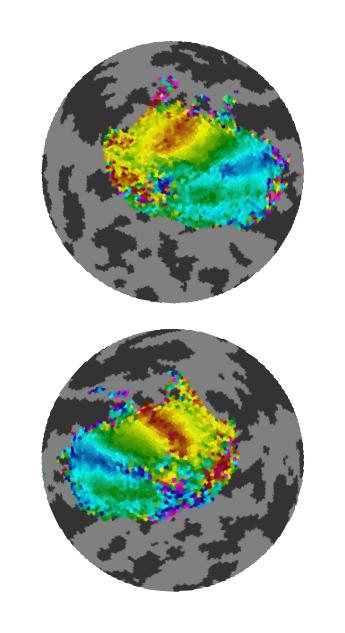

In [9]:
(fig, (left_ax, right_ax)) = plt.subplots(2,1, figsize=(1,2), dpi=72*4)
# Make sure there isn't a bunch of extra space around them.
fig.subplots_adjust(0,0,1,1,0,0)
# We provide the cortex_plot function with a property name that it should
# use for the color; we also provide a colormap (cmap).

ny.cortex_plot(flatmaps['lh'], axes=left_ax,
               color=flatmap_quota_lh,
               cmap='polar_angle_lh', mask=r2_mask_lh, alpha=0.9,underlay=underlay_lh)
ny.cortex_plot(flatmaps['rh'], axes=right_ax,
               color=flatmap_quota_rh,
               cmap='polar_angle_rh', mask=r2_mask_rh, alpha=0.9,underlay=underlay_rh)

left_ax.axis('off')
right_ax.axis('off')
plt.gcf().set_facecolor('white')

## 分析十一、量化考察初级视觉皮层复杂特征调制的视野拓扑组织规律

### 结果 11.1：从特征轴上分析：构建距离矩阵，得到ang、ecc、radial距离对调谐差异的效应

In [7]:
#路径设置
work_dir = '/nfs/z1/userhome/zzl-xsk/Featurespace'
cifti_path = '/nfs/z1/userhome/zzl-xsk/NOD/derivatives/ciftify'
masked_retino_path = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel')
pca_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-pca')
ica_voxelwisemodel_path = pjoin(work_dir, 'build/roi-voxelwisemodel_feature-ica')
concate_path = pjoin(work_dir, 'prep/roi-concate')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
#参数设置
subs = [f'sub-{isub:02d}' for isub in range(1, 10)]
layername = 'googlenet-conv2'
roiname = 'V1'

In [8]:
from sklearn.linear_model import LinearRegression
allsub_weights = np.nan * np.zeros((9 , 3))
for isub, sub in enumerate(subs):
    #读取被试的tuning，并进行标准化
    voxelwise_model = np.load(pjoin(ica_voxelwisemodel_path, sub, f'{layername}/{sub}_{roiname}-fullm-coef.npy'))#[:, channels]
    voxelwise_model = zscore(voxelwise_model, axis=1)
    #读取体素信息，并选取ecc小于8的体素
    voxels = np.load(pjoin(concate_path, sub, f'{sub}_layer-{layername}_{roiname}-voxel.npy'))
    prior_prf = nib.load(pjoin(masked_retino_path, sub, f'{sub}_masked-prior-prf.dscalar.nii')).get_fdata()
    ecc_select_voxels = np.where((prior_prf[1, :] <= 8)==True)[0]
    select_voxels = np.intersect1d(voxels, ecc_select_voxels)
    # select_voxels = select_voxels[np.where(select_voxels < 29706)[0]]
    select_voxel_idx = np.squeeze([np.where(voxels == i)[0] for i in  select_voxels])
    voxelwise_model = voxelwise_model[select_voxel_idx, :]


    corr_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
    distance_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
    ecc_difference_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))
    ang_difference_matrix = np.nan * np.zeros((len(select_voxels), len(select_voxels)))


    prior_ecc = prior_prf[1, :]
    prior_ang = prior_prf[0, :]

    for i, avoxel in enumerate(select_voxels):
        a_weights = voxelwise_model[i, :]
        a_ecc = prior_ecc[avoxel]
        a_ang = prior_ang[avoxel]
        for j, bvoxel in enumerate(select_voxels):
            b_weights = voxelwise_model[j, :]
            b_ecc = prior_ecc[bvoxel]
            b_ang = prior_ang[bvoxel]

            corr = np.corrcoef(a_weights, b_weights)[0, 1]
            corr_matrix[i, j ] = corr

    for i, avoxel in enumerate(select_voxels):
        a_weights = voxelwise_model[i, :]
        a_ecc = prior_ecc[avoxel]
        a_ang = prior_ang[avoxel]
        a_theta = a_ang * np.pi /180
        a_x, a_y = a_ecc * np.cos(a_theta), a_ecc * np.sin(a_theta)

        for j, bvoxel in enumerate(select_voxels):
            b_weights = voxelwise_model[j, :]
            b_ecc = prior_ecc[bvoxel]
            b_ang = prior_ang[bvoxel]
            b_theta = b_ang * np.pi /180
            b_x, b_y = b_ecc * np.cos(b_theta), b_ecc * np.sin(b_theta)

            ecc_difference = abs(a_ecc - b_ecc)
            ecc_difference_matrix[i, j ] = ecc_difference

            ang_difference = ang_difference = abs(a_theta - b_theta)
            ang_difference = (ang_difference) % (np.pi/2)
            ang_difference_matrix[i, j ] = ang_difference

            distance = np.sqrt((a_x - b_x) ** 2 + (a_y - b_y) ** 2)
            distance_matrix[i, j] = distance

    #回归模型
    x1 = zscore(ang_difference_matrix.flatten())
    x2 = zscore(ecc_difference_matrix.flatten())
    x3 = zscore(distance_matrix.flatten())
    X = np.column_stack((x1, x2, x3))

    y = zscore(corr_matrix.flatten())

    lr = LinearRegression()
    lr.fit(X, y)
    weights = lr.coef_
    allsub_weights[isub, :] = weights

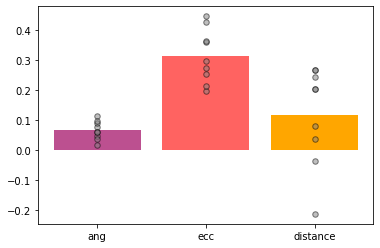

<Figure size 360x360 with 0 Axes>

In [10]:
colors= ["#bc5090","#ff6361","#ffa600"]
mean_weights = -np.nanmean(allsub_weights, axis=0)
labels = ['ang', 'ecc', 'distance']
positions = np.arange(len(labels))  # 柱状图的中心位置
plt.bar(labels, mean_weights, color=colors)

#画上每个被试的散点图

for isub, sub_weights in enumerate(allsub_weights):
    for idx, weight in enumerate(sub_weights):
        plt.scatter(positions[idx], -weight, s=30, color='grey', alpha=0.5, edgecolor='black', linewidth=1, zorder=3)
plt.gcf().set_facecolor('white')
plt.figure(figsize=(5,5))
plt.show()

## 补分析五、预测表现随特征个数

In [17]:
axis_type = 'pca'
performance_dir = pjoin(work_dir, f'build/roi-concatemodel_feature-{axis_type}')

splithalf_corrs, traintest_corrs = [], []
for sub in [f'sub-0{_+1}' for _ in range(9)]:

    splithalf_file = f'{sub}_model-googlenet-conv2-linear_V1_split-half-corr-v-featurenum.npy'
    traintest_file = f'{sub}_model-googlenet-conv2-linear_V1_train-test-corr-v-featurenum.npy'

    splithalf_corrs.append(np.load(pjoin(performance_dir, splithalf_file))[np.array([1,3]),:].mean(axis=0)) 
    traintest_corrs.append(np.load(pjoin(performance_dir, traintest_file))[-1,:]) 

In [13]:
mean_splithalf_corrs = np.array(splithalf_corrs).mean(axis=0)

In [22]:
selectedcorrs = np.array(traintest_corrs)[:,12]

In [23]:
origincorrs = np.load(pjoin(work_dir, 'build/roi-concatemodel_feature-pca/performance/all-sub_model-googlenet-conv2-linear_V1_test-corr.npy'))

In [24]:
from scipy.stats import ttest_rel

# 进行配对 t 检验
t_statistic, p_value = ttest_rel(selectedcorrs, origincorrs)
t_statistic, p_value

(1.3892454037240272, 0.20220321023449844)

12

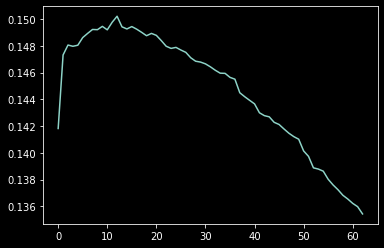

In [14]:
plt.plot(mean_splithalf_corrs)
np.argmax(mean_splithalf_corrs)

8

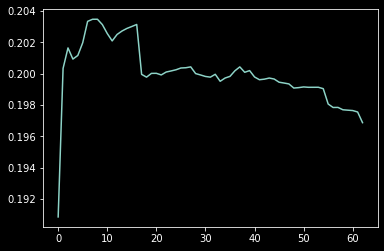

In [10]:
plt.plot(splithalf_corr[np.array([1,3]),:].mean(axis=0))
np.argmax(splithalf_corr[np.array([1,3]),:].mean(axis=0))

In [7]:
np.argmax(splithalf_corr[np.array([1,3]),:].mean(axis=0))

2